# The Asteroseismic Imprints of Mass Transfer
by [Tom Wagg](https://tomwagg.com)$^{1}$

$^1$[]()_Department of Astronomy, University of Washington, Seattle, WA, USA_

This notebook reproduces the figures and results from the paper of the same title.

In [2]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

import astropy.constants as const
import astropy.units as u

from astropy.visualization import quantity_support
quantity_support()

from ipywidgets import interact, IntSlider, FloatSlider

import seaborn as sns

In [3]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.6*fs,
          'axes.labelsize': 0.8*fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load and prep data

Add some custom imports will Earl's `mesagrid` package and my mesa plotting scripts.

In [6]:
from importlib import reload
import sys
sys.path.append("../")

import mesagrid
reload(mesagrid);

sys.path.append("../helpers")
import mesaplot_tom as mpt
reload(mpt);

In [7]:
tracks = {}
for folder, label in zip(["4_3_5_mdm100", "4_3_5_mdm50", "4_3_5_mdm10", "4_3_5_mdm1"],
                         [r"$m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 100 \, {\rm cm^2 \, s^{-1}}$",
                          r"$m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 50 \, {\rm cm^2 \, s^{-1}}$",
                          r"$m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 10 \, {\rm cm^2 \, s^{-1}}$",
                          r"$m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 1 \, {\rm cm^2 \, s^{-1}}$"]):
    path = os.path.join("../output/cluster/binaries", folder)
    tracks[folder] = [mesagrid.Track(path, dir_name="LOGS_star1", parameters=f"{label} (Donor)"),
                     mesagrid.Track(path, dir_name="LOGS_star2", parameters=f"{label} (Accretor)")]

In [8]:
D_mix_tracks = {}
for folder, label in zip(["D_15", "D_20", "D_25", "D_30", "D_35", "D_40", "D_45"],
                         [r"$D_{\rm min} = 15 \, {\rm cm^2 \, s^{-1}}$",
                          r"$D_{\rm min} = 20 \, {\rm cm^2 \, s^{-1}}$",
                          r"$D_{\rm min} = 25 \, {\rm cm^2 \, s^{-1}}$",
                          r"$D_{\rm min} = 30 \, {\rm cm^2 \, s^{-1}}$",
                          r"$D_{\rm min} = 35 \, {\rm cm^2 \, s^{-1}}$",
                          r"$D_{\rm min} = 40 \, {\rm cm^2 \, s^{-1}}$",
                          r"$D_{\rm min} = 45 \, {\rm cm^2 \, s^{-1}}$"]):
    path = os.path.join("../output/cluster/binaries/Dmix_grid", folder)
    D_mix_tracks[folder] = [mesagrid.Track(path, dir_name="LOGS_star1", parameters=f"{label} (Donor)"),
                     mesagrid.Track(path, dir_name="LOGS_star2", parameters=f"{label} (Accretor)")]

In [9]:
single_tracks = {}
Ms = np.arange(3.0, 6.1, 0.1)
for M in Ms:
    folder = f"M_{M:1.1f}"
    single_tracks[folder] = mesagrid.Track(dir=f"../output/cluster/singles_grid/{folder}", parameters=folder)

In [10]:
single_tracks_mdm20 = {}
Ms = np.arange(3.0, 6.1, 0.1)
for M in Ms:
    folder = f"M_{M:1.1f}"
    single_tracks_mdm20[folder] = mesagrid.Track(dir=f"../output/cluster/singles_grid_mdm20/{folder}", parameters=folder)

# Binary Evolution

In [9]:
def add_singles_tracks(fig, ax, Ms=None, colour="lightgrey", an_every=0.5):
    if Ms is None:
        Ms = np.arange(3.0, 6.1, 0.1)
    for M in Ms:
        folder = f"M_{M:1.1f}"
        ans = fr"$M = {{{M:1.1f}}} {{\rm M_\odot}}$" if M.round(1) % an_every == 0.0 else None
        fig, ax = mpt.simple_hr(single_tracks[folder], fig=fig, ax=ax, show=False, cbar_var=None,
                                annotate_start=ans, s=0, line_colour=colour)
    return fig, ax

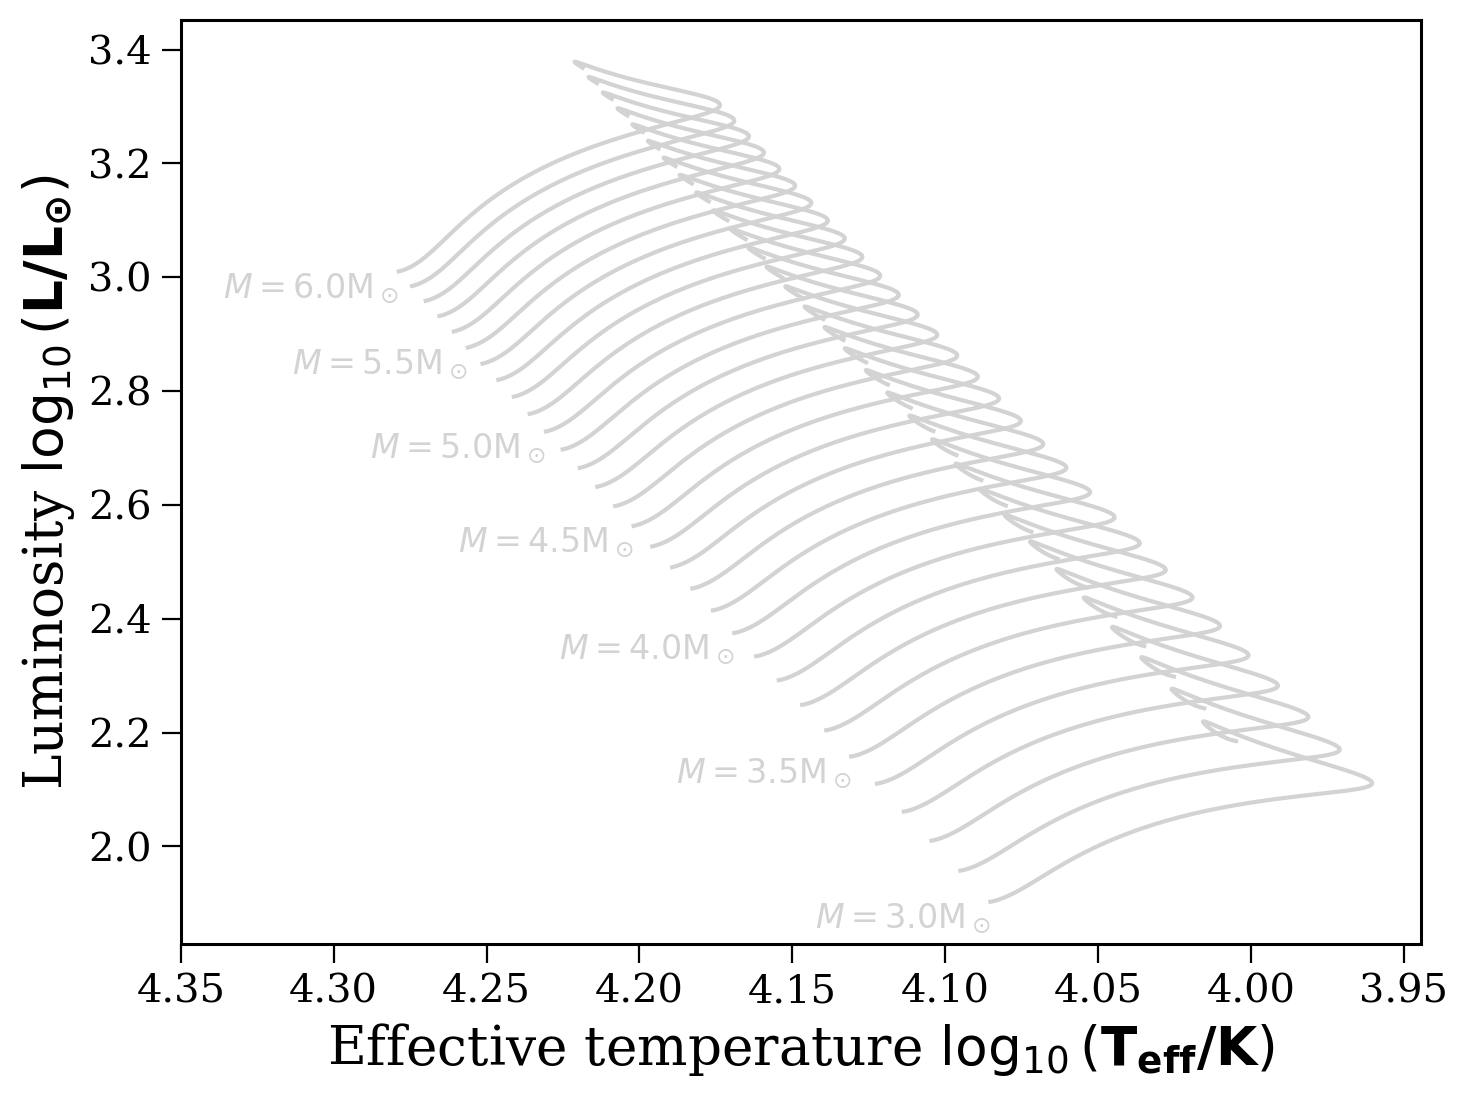

In [19]:
fig, ax = None, None
fig, ax = add_singles_tracks(fig, ax)
ax.set_xlim(left=4.35)
plt.show()

In [10]:
def append_surface_He_abundance(track):
    surface_he = [track.profiles[i].iloc[0]["y_mass_fraction_He"] for i in range(len(track.profiles))]
    track.history.loc[:, "surface_he"] = surface_he

In [21]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

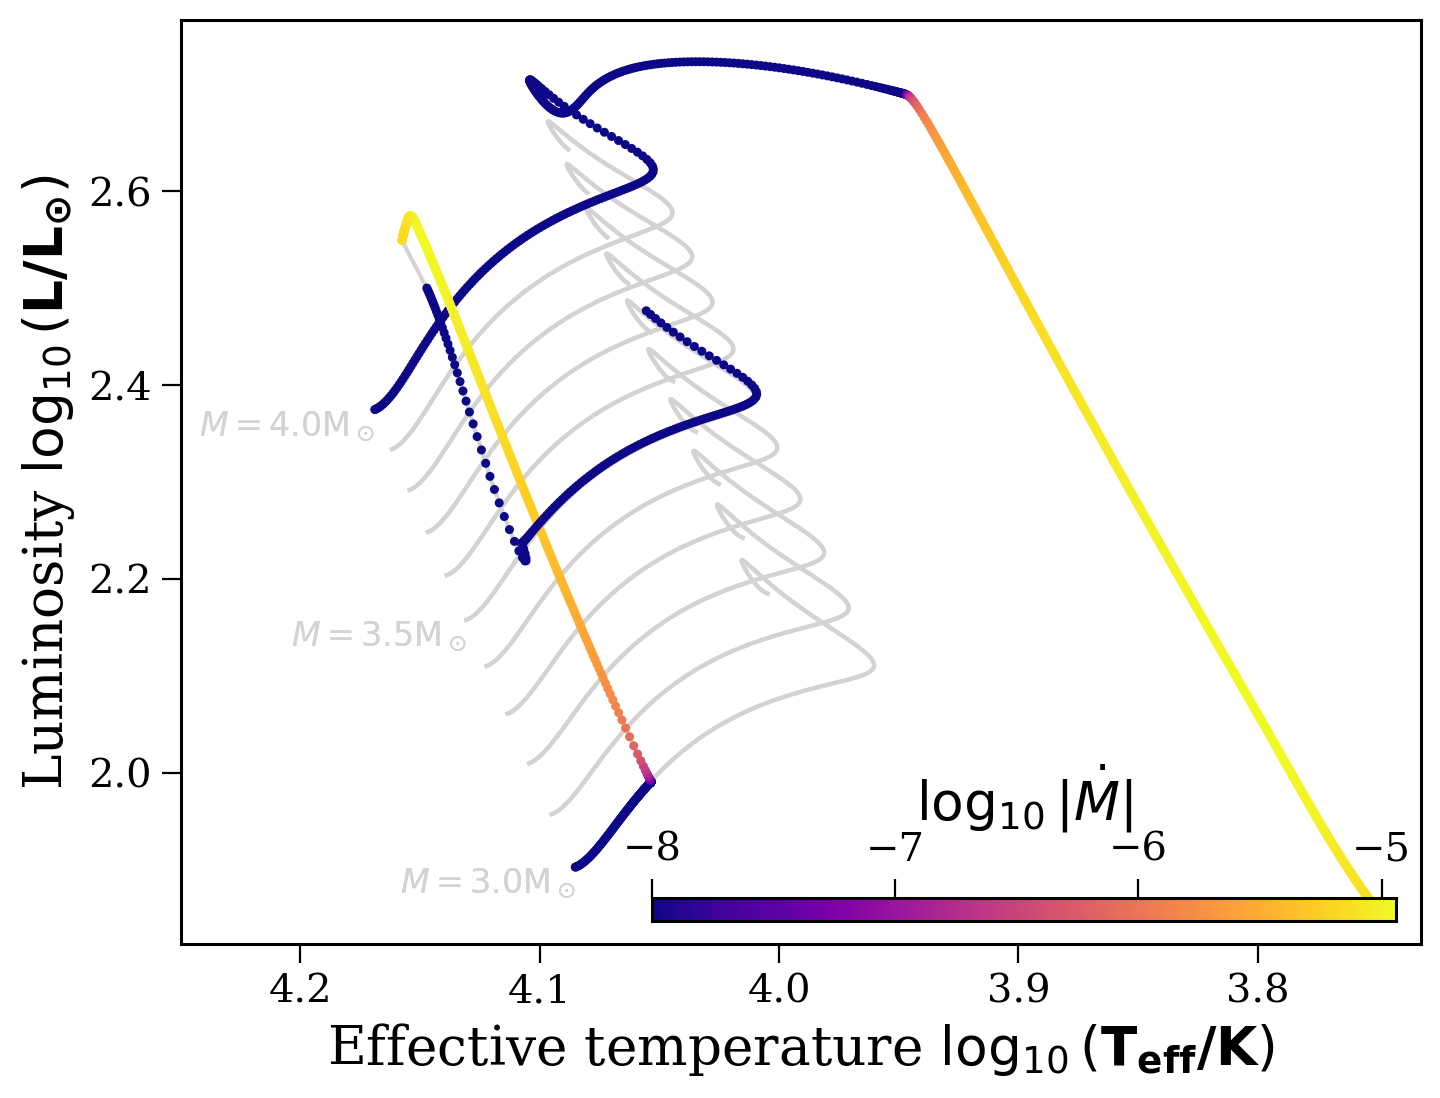

In [27]:
for folder, label in zip(["4_3_5_mdm100"],
                         [r"$m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}$"]):
    t1, t2 = tracks[folder]

    fig, ax = None, None
    for track, cmap in zip(tracks[folder], ["plasma", "plasma"]):
        if "surface_he" not in track.history.columns:
            append_surface_He_abundance(track)
        fig, ax = mpt.simple_hr(track, fig=fig, ax=ax, show=False, s=5, cmap=cmap,
                                cbar_var="log_abs_mdot", cbar_label=r"$\log_{10} |\dot{M}|$", vmin=-8)#, vmin=0.275, vmax=0.385)
        fig, ax = add_singles_tracks(fig, ax, Ms=np.arange(3.0, 4.1, 0.1))
    ax.set_xlim(left=4.25)

    # plt.savefig("figures/HRD_binary.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    # fig, ax = plt.subplots(figsize=(8, 4))

    # for t, l in zip([t1, t2], ["Donor", "Accretor"]):
    #     dXc = t.history["center_h1"].shift(1) - t.history["center_h1"]
    #     dXc.iloc[0] = dXc.iloc[1]

    
    #     ax.plot(t.history["model_number"], np.abs(dXc) / 10**(t.history["log_dt"]), label=l)
    # # ax.plot(t2.history["model_number"], t2.history["log_dt"])
    # ax.set_title(folder)
    # ax.set_yscale("log")
    # ax.legend()
    # ax.set_xlabel("Model Number")
    # ax.set_ylabel("dXc / dt [1/year]", fontsize=0.7*fs)
    # ax.set_ylim(1e-12)
    # plt.show()

In [ ]:
append_surface_He_abundance(tracks["detach_2.5_2_3"][1])

In [10]:
def get_years_after_mod(track, mod, years, verbose=True):
    start_time = track.history.loc[mod - 1]["star_age"]
    end_time = start_time + years
    
    diff = np.abs(track.history["star_age"].values - end_time)
    argmin_diff = np.argmin(diff)
    
    actual_time_step = track.history["star_age"].values[np.argmin(diff)] - start_time

    if verbose:
        print(f"The closest time I can find is {actual_time_step / 1e3:1.2f} kyr after this model")
    
    return track.history["model_number"][argmin_diff]

In [11]:
def accretor_rel_MT(track, years=None, rel_to="start", extra_title=None, verbose=False):

    if rel_to == "both":
        accretor_rel_MT(track, years=years, rel_to="start", extra_title=extra_title)
        accretor_rel_MT(track, years=years, rel_to="end", extra_title=extra_title)
        return

    mt_mod_nums = track.history[track.history["log_abs_mdot"] > -10.0]["model_number"]
    mt_start, mt_end = mt_mod_nums.min(), mt_mod_nums.max()

    if years is None:
        if rel_to == "start":
            t_start, t_end = track.history.loc[mt_start - 1]["star_age"], track.history.loc[mt_end - 1]["star_age"]
            years = np.linspace(t_start, t_end, 5) - t_start
        else:
            t_start, t_end = track.history.loc[mt_end - 1]["star_age"], track.history.iloc[-1]["star_age"]
            years = np.linspace(t_start, t_end, 5) - t_start

    fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={"width_ratios": [16, 1]})
    fig.subplots_adjust(wspace=0.0)

    ax, cbar_ax = axes

    cmap = plt.get_cmap("cividis_r")

    colours = cmap(np.linspace(0, 1, len(years)))
    inds = range(len(years))

    for year, col, ind in zip(years, colours, inds):
        mod = get_years_after_mod(track, mt_start if rel_to == "start" else mt_end, year, verbose=verbose)
        ax.plot(track.profiles[mod - 1]["mass"], track.profiles[mod - 1]["x_mass_fraction_H"], color=col,
                zorder=10 + len(years) - ind)# if rel_to == "start" else None)
    ax.set_ylim(0, 1)

    norm = mpl.colors.Normalize(vmin=min(years) / 1e6, vmax=max(years) / 1e6)

    cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
    cb1.ax.tick_params(labelsize=0.5*fs)
    cb1.set_label(f"Time after mass\ntransfer f{'starts' if rel_to == 'start' else 'ends'} [Myr]", fontsize=0.5*fs)

    ax.set_xlabel(r"Mass $\mathbf{M/M_{\odot}}$")
    ax.set_ylabel(r"Hydrogren mass fraction", fontsize=0.5*fs)

    title = f"Accretor composition ({'During' if rel_to == 'start' else 'Post'} MT)"
    title = title + f" - {extra_title}" if extra_title is not None else title
    ax.set_title(title)

    plt.show()

In [ ]:
accretor_rel_MT(tracks["2.5_2_3_tm"][1], rel_to='both',
                extra_title=r"$m_1 = 2.5, m_2 = 2 {\rm M_\odot}$, $P = 3 \, {\rm days}$" + "\nwith Thermohaline mixing")

In [ ]:
accretor_rel_MT(tracks["detach_2.5_2_4_tm"][1], rel_to='both',
                extra_title=r"$m_1 = 2.5, m_2 = 2 {\rm M_\odot}$, $P = 4 \, {\rm days}$, with Thermohaline mixing")

In [ ]:
accretor_rel_MT(tracks["detach_2.5_2_3"][1], rel_to='both',
                extra_title=r"$m_1 = 2.5, m_2 = 2 {\rm M_\odot}$, $P = 3 \, {\rm days}$")

In [ ]:
accretor_rel_MT(tracks["detach_2.5_2_4"][1], rel_to='both',
                extra_title=r"$m_1 = 2.5, m_2 = 2 {\rm M_\odot}$, $P = 4 \, {\rm days}$")

In [ ]:
accretor_rel_MT(tracks["detach_4_3_5"][1], rel_to="both",
                extra_title=r"$m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}$")

In [ ]:
track.history.columns[100:]

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
for folder, label in zip(["detach_2.5_2_4", "detach_2.5_2_3"],
                         [r"$m_1 = 2.5, m_2 = 2 {\rm M_\odot}$, $P = 4 \, {\rm days}$",
                          r"$m_1 = 2.5, m_2 = 2 {\rm M_\odot}$, $P = 3 \, {\rm days}$"]):
    fig, ax = plt.subplots(figsize=(8, 4))
    for track in reversed(list(tracks[folder])):
        scatter = ax.scatter(track.history["star_mass"], track.history["log_R"], c=track.history["log_abs_mdot"],
                            vmin=-8, s=5, cmap="plasma")

    cbar = fig.colorbar(scatter, label=r"$\log_{10} (|\dot{M}| / {\rm M_\odot \, yr^{-1}})$")

    ylims = ax.get_ylim()

    ax.plot(track.history["star_mass"], np.log10(track.history["rl_1"]), color="grey", linestyle="dotted", lw=2, zorder=-1)
    ax.set_ylim(ylims)

    ax.set_xlabel(r"Mass, $[\rm M_\odot]$")
    ax.set_ylabel(r"Radius, $\log_{10} (R / {\rm R_\odot})$")

    ax.set_title(label)
    plt.show()

# Kippenhahns

In [ ]:
import mesaPlot as mp
m=mp.MESA()
p=mp.plot()

In [ ]:
m.log_fold='../output/cluster/binaries/detachers/2.5_2_3/LOGS_star1'
m.loadHistory()

In [ ]:
m.hist["model_number"]

In [ ]:
p.plotKip3(m, show_burn=True, show_mix=True, mix_hatch=False, mod_min=1, mod_max=2957)

In [ ]:
track = tracks["detach_4_3_5"][1]
mt_mod_nums = track.history[track.history["log_abs_mdot"] > -10.0]["model_number"]
mt_start, mt_end = mt_mod_nums.min(), mt_mod_nums.max()

In [ ]:
mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01])

# MOre

In [ ]:
create_GYRE_bash(mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]))

In [ ]:
create_GYRE_bash(mpt.find_closest_model_number(tracks["4_3_5_mdm10"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]))

In [ ]:
create_GYRE_bash(mpt.find_closest_model_number(tracks["4_3_5_mdm1"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]))

In [13]:
create_GYRE_bash(mpt.find_closest_model_number(single_tracks["M_3.5"], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]))

"echo -n 'profile76.data.GYRE,profile92.data.GYRE,profile109.data.GYRE,profile127.data.GYRE,profile145.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"

In [21]:
def create_GYRE_bash(mods, procs=6, script="/afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh"):
    mods_strings = [f"profile{mod}.data.GYRE" for mod in mods]
    return "echo -n '" + ','.join(mods_strings) + "' | xargs -d ',' -P " + str(min(procs, len(mods_strings)))\
        + " -I {} " + script + " -i {} -t 1 -e"

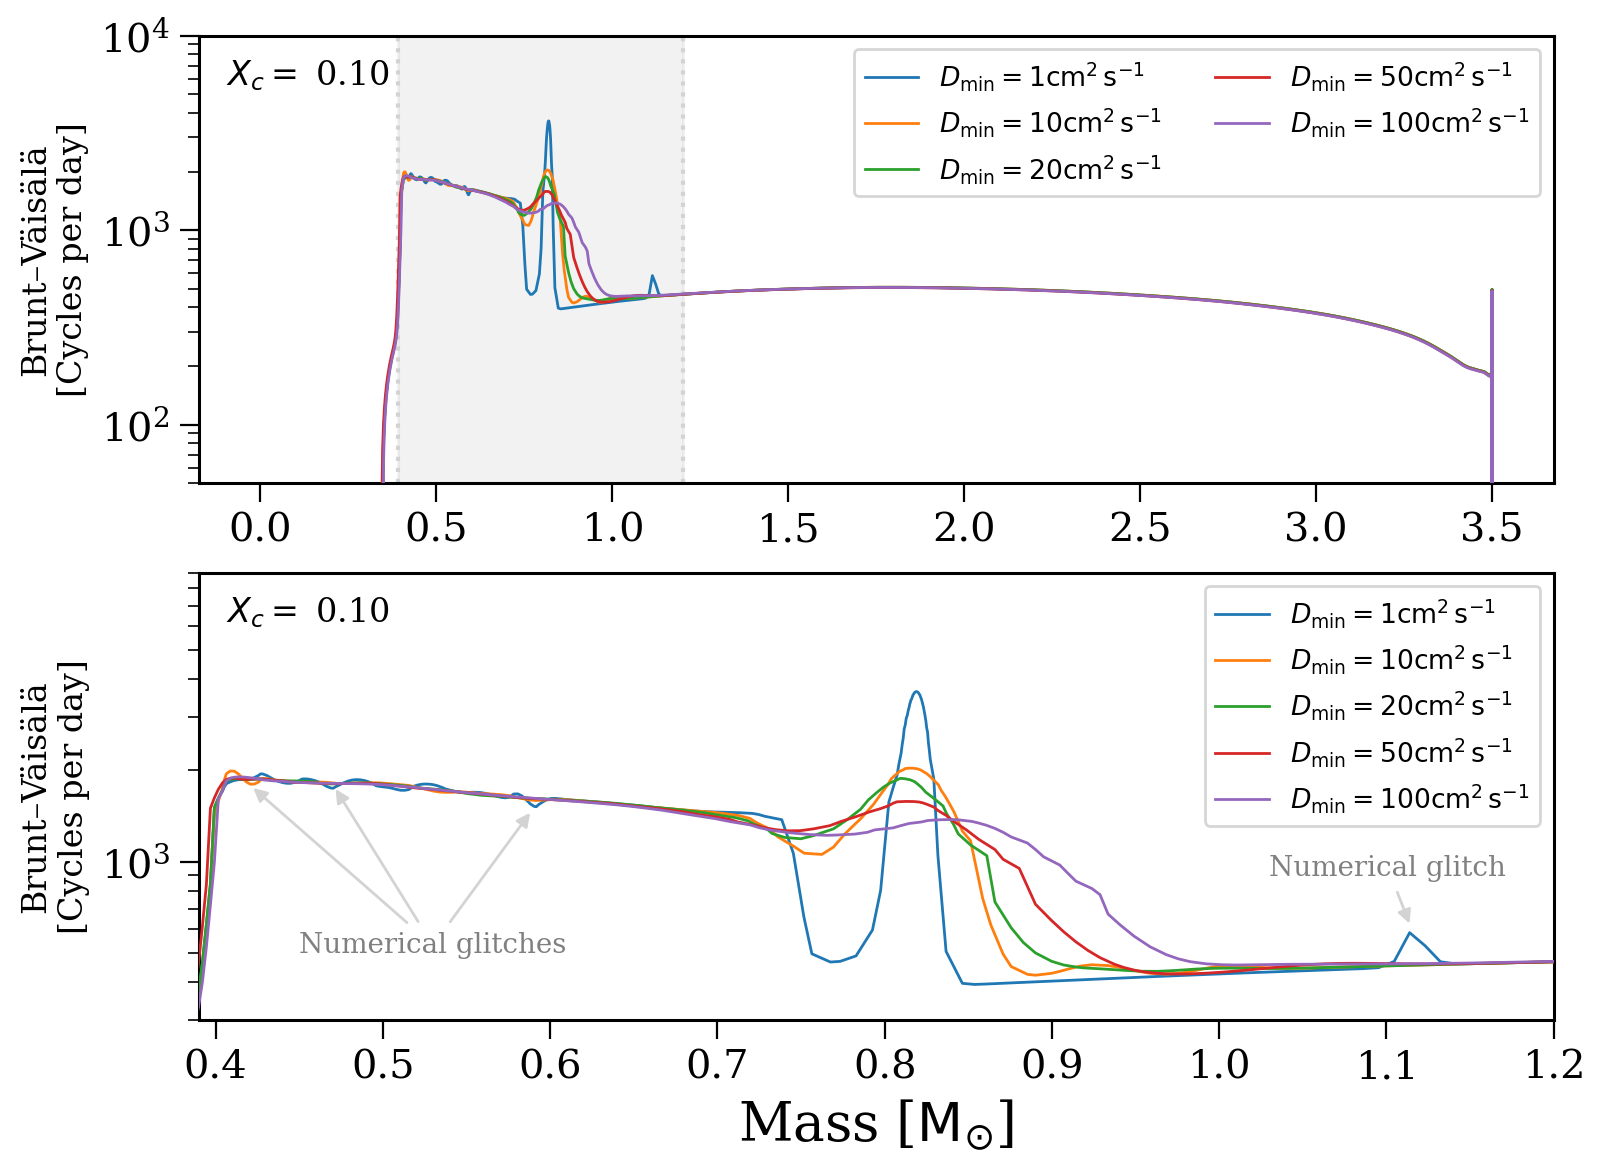

In [183]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

fig, ax = mpt.plot_BV_profile(X_c=0.1,
                              tracks=list(reversed([tracks["4_3_5_mdm100"][1], tracks["4_3_5_mdm50"][1],
                                                    D_mix_tracks["D_20"][1],
                                                    tracks["4_3_5_mdm10"][1], tracks["4_3_5_mdm1"][1]])),
                              labels=list(reversed([r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 50 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 1 {\rm cm^{2} \, s^{-1}}$"])),
                              colours=[None, None, None, None, None], label_with="an", fill=False, show=False, fig=fig, ax=axes[0])

fig, ax = mpt.plot_BV_profile(X_c=0.1,
                              tracks=list(reversed([tracks["4_3_5_mdm100"][1], tracks["4_3_5_mdm50"][1],
                                                    D_mix_tracks["D_20"][1],
                                                    tracks["4_3_5_mdm10"][1], tracks["4_3_5_mdm1"][1]])),
                              labels=list(reversed([r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 50 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$",
                                      r"$D_{\rm min} = 1 {\rm cm^{2} \, s^{-1}}$"])),
                              colours=[None, None, None, None, None], label_with="an", fill=False, show=False, fig=fig, ax=axes[1], legend_loc="upper right")

ax.get_legend().remove()
ax.legend(ncol=1, fontsize=0.4*fs)

fig.subplots_adjust(hspace=0.2)

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

axes[1].set_xlim(0.39, 1.2)
axes[1].set_ylim(bottom=3e2, top=9e3)

def add_arrow(ax, text, start, end, hide_text=False):
    ax.annotate(text, xytext=start, xy=end,
                 arrowprops=dict(arrowstyle="-|>", color="lightgrey"),
                 color="grey" if not hide_text else "white", zorder=10)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.47, 1.8e3), hide_text=True)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.59, 1.5e3), hide_text=True)
add_arrow(axes[1], "Numerical glitches", (0.45, 5e2), (0.42, 1.8e3))


add_arrow(axes[1], "Numerical glitch", (1.03, 9e2), (1.115, 6e2))

plt.savefig("figures/min_D_mix_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

Parsing $m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 10 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1045/1045 [00:05<00:00, 181.31it/s]


Parsing $D_{\rm min} = 15 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1046/1046 [00:09<00:00, 106.20it/s]


Parsing $D_{\rm min} = 20 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1046/1046 [00:05<00:00, 176.51it/s]


Parsing $D_{\rm min} = 25 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1046/1046 [00:12<00:00, 82.92it/s]


Parsing $D_{\rm min} = 30 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1045/1045 [00:10<00:00, 103.36it/s]


Parsing $D_{\rm min} = 35 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1045/1045 [00:09<00:00, 106.24it/s]


Parsing $D_{\rm min} = 40 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1050/1050 [00:13<00:00, 77.48it/s] 


Parsing $D_{\rm min} = 45 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1047/1047 [00:12<00:00, 85.80it/s]
/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py:241: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


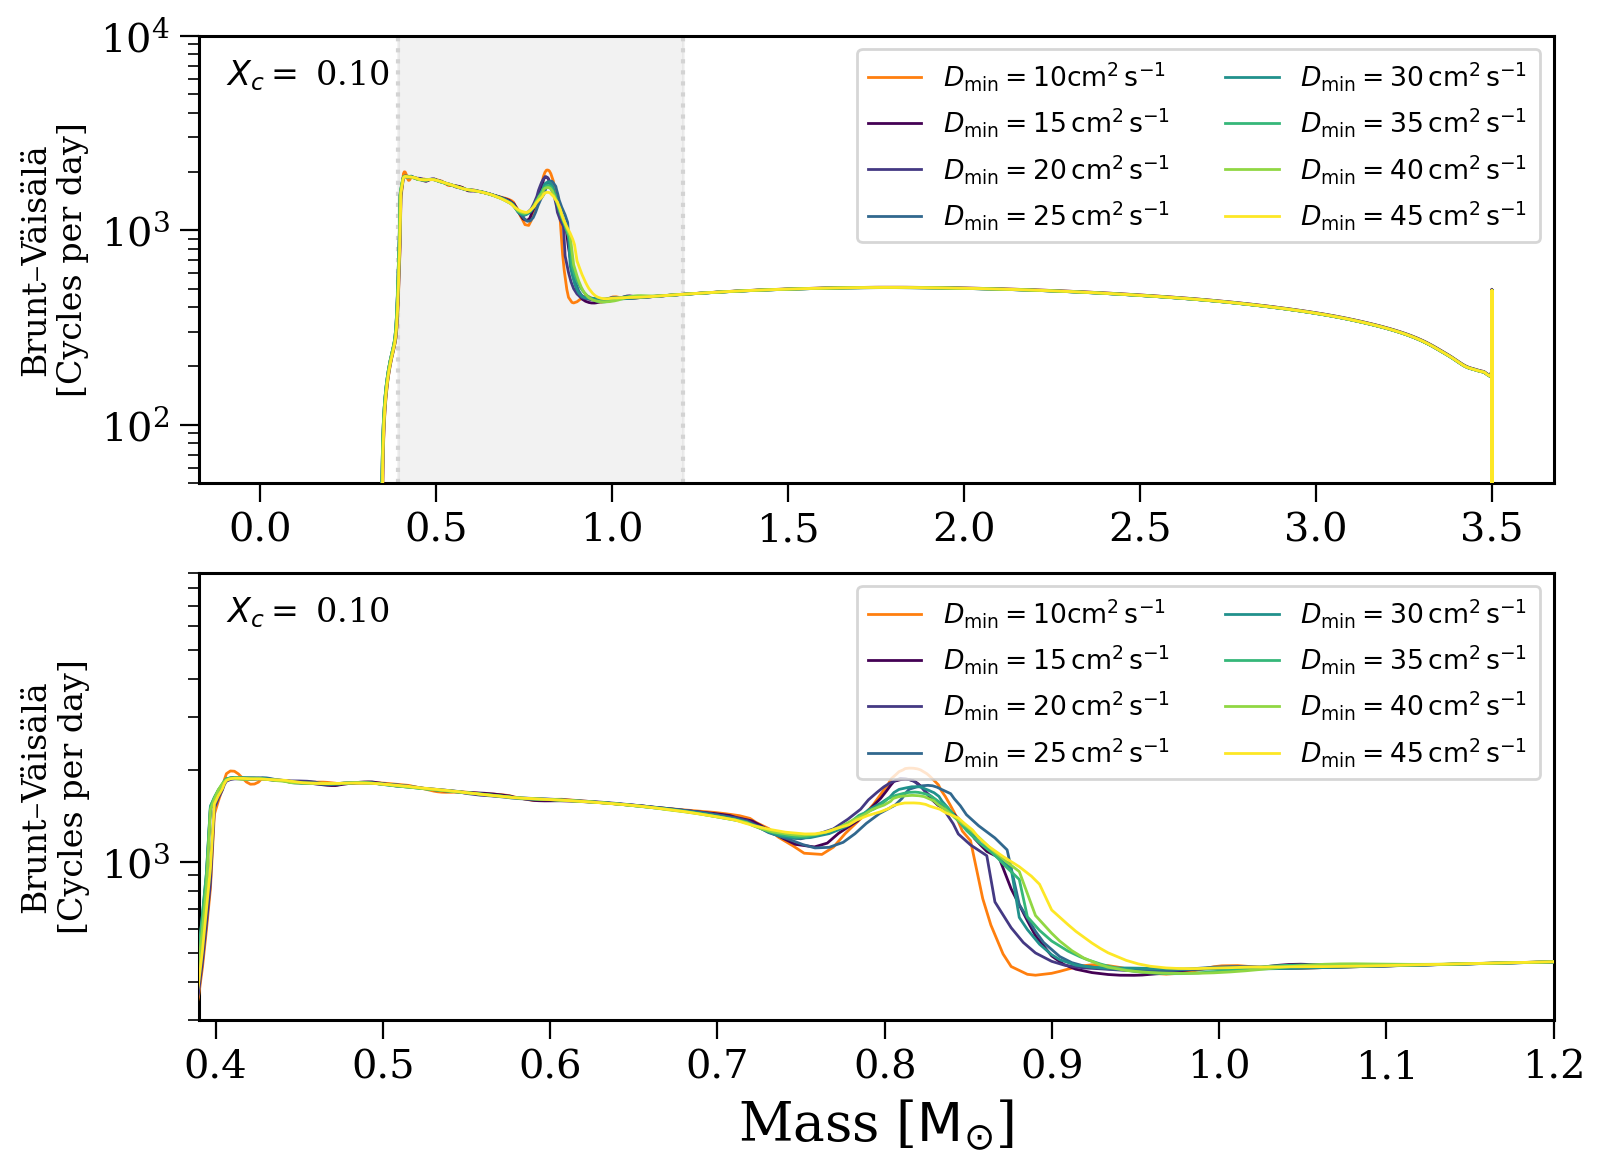

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

reverse = False

d_zoom_tracks = [tracks["4_3_5_mdm10"][1]] + [t[1] for t in list(D_mix_tracks.values())]
d_zoom_labels = [r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$"] + [t.parameters.split("(")[0] for t in [t[1] for t in list(D_mix_tracks.values())]]
d_zoom_cols = ["tab:orange"] + [plt.get_cmap("viridis", 7)(i) for i in range(7)]

if reverse:
    d_zoom_tracks = list(reversed(d_zoom_tracks))
    d_zoom_tracks = list(reversed(d_zoom_labels))
    d_zoom_tracks = list(reversed(d_zoom_cols))

fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=d_zoom_tracks, labels=d_zoom_labels,
                              colours=d_zoom_cols, label_with="an", fill=False, show=False, fig=fig, ax=axes[0])

fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=d_zoom_tracks, labels=d_zoom_labels,
                              colours=d_zoom_cols, label_with="an", fill=False, show=False, fig=fig, ax=axes[1])

fig.subplots_adjust(hspace=0.2)

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

axes[1].set_xlim(0.39, 1.2)
axes[1].set_ylim(bottom=3e2, top=9e3)
# plt.savefig("figures/min_D_mix_comparison.pdf", format="pdfs[i]s[i]s[i]s[i]", bbox_inches="tight")
plt.show()

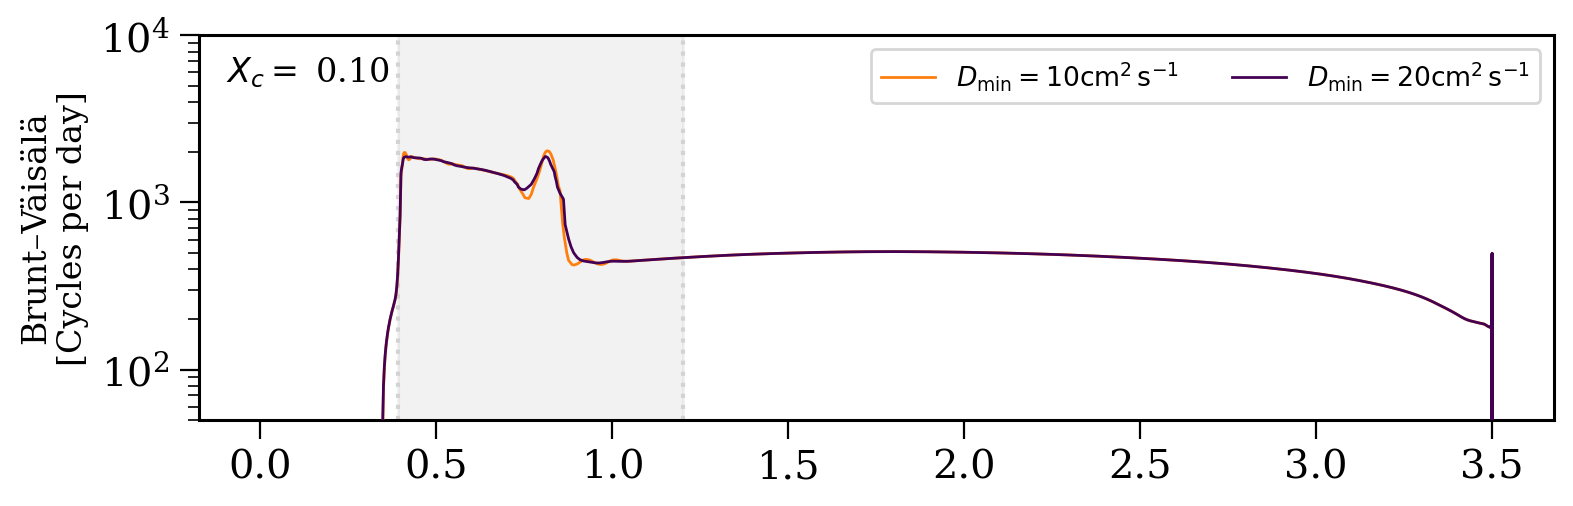

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))

d_zoom_tracks = [tracks["4_3_5_mdm10"][1]] + [D_mix_tracks["D_20"][1]]
d_zoom_labels = [r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$", r"$D_{\rm min} = 20 {\rm cm^{2} \, s^{-1}}$"]

fig, ax = mpt.plot_BV_profile(X_c=0.1, tracks=d_zoom_tracks, labels=d_zoom_labels,
                              colours=d_zoom_cols, label_with="an", fill=False, show=False, fig=fig, ax=ax)

fig.subplots_adjust(hspace=0.2)

axes = [ax]

axes[0].set_xlabel("")
axes[0].axvline(0.39, linestyle="dotted", color="lightgrey")
axes[0].axvline(1.2, linestyle="dotted", color="lightgrey")
axes[0].axvspan(0.39, 1.2,  alpha=0.1, color="grey")

# plt.savefig("figures/min_D_mix_comparison.pdf", format="pdfs[i]s[i]s[i]s[i]", bbox_inches="tight")
plt.show()

# Period spacing

In [ ]:
mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]) - 1

In [ ]:
def append_pi_0(track):
    track.history.loc[:, "pi_0"] = [mpt.get_pi_0(track.profiles[i]) for i in range(len(track.profiles))]

In [ ]:
for track in single_tracks.values():
    append_pi_0(track)

In [ ]:
append_pi_0(tracks["4_3_5_mdm100"][1])

In [ ]:
(Ms - 3) / 3

In [ ]:
colours = plt.get_cmap("binary_r")(np.linspace(0.1, 1, len(Ms)))

fig, axes = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={"width_ratios": [16, 1]})
fig.subplots_adjust(wspace=0.0)

ax, cbar_ax = axes

i = 0
for key, track in single_tracks.items():
    ax.plot(track.history["center_h1"], track.history["pi_0"], color=colours[i])
    i += 1

ax.plot(tracks["4_3_5_mdm100"][1].history["center_h1"],
         tracks["4_3_5_mdm100"][1].history["pi_0"],
         color="tab:red", zorder=10, lw=2)



norm = mpl.colors.Normalize(vmin=min(Ms), vmax=max(Ms))

cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap="binary_r", norm=norm)
cb.ax.tick_params(labelsize=0.5*fs)
cb.set_label(f"Mass")

# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel("Central H abundance")
ax.set_ylabel(r"$\Pi_0\, [\rm s]$")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for key, track in single_tracks.items():
    ax.plot(track.history["center_h1"], track.history["pi_0"], color="lightgrey", lw=0.5)

ax.plot(tracks["4_3_5_mdm100"][1].history["center_h1"],
         tracks["4_3_5_mdm100"][1].history["pi_0"],
         color="tab:red", zorder=10, lw=1, label="Mass-gainer")

ax.plot(single_tracks["M_3.0"].history["center_h1"], single_tracks["M_3.0"].history["pi_0"], color="grey", lw=0.5)
ax.plot(single_tracks["M_3.5"].history["center_h1"], single_tracks["M_3.5"].history["pi_0"], color="grey", lw=0.5, label="Single star (3.0 and 3.5)")

ax.plot(track.history["center_h1"], track.history["pi_0"], color="lightgrey", lw=0.5, label="Other single stars")

ax.legend()


# ax.set_yscale("log")
ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel(r"Central H abundance, $X_c$")
ax.set_ylabel(r"$\Pi_0\, [\rm s]$")

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
h1_to_pi0 = interp1d(single_tracks["M_3.5"].history["center_h1"], single_tracks["M_3.5"].history["pi_0"])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ratio = tracks["4_3_5_mdm100"][1].history["pi_0"] / h1_to_pi0(tracks["4_3_5_mdm100"][1].history["center_h1"])

ax.plot(tracks["4_3_5_mdm100"][1].history["center_h1"], ratio)
ax.axhline(1.0, linestyle="dotted", color="lightgrey")


# ax.set_yscale("log")
# ax.set_xscale("log")
ax.invert_xaxis()

ax.set_xlabel(r"Central H abundance, $X_c$")
ax.set_ylabel(r"$\Pi_0 ({\rm binary}) / \Pi_0 ({\rm single 3.5})$")

In [ ]:
pi_0 = [mpt.get_pi_0(single_tracks["M_3.0"].profiles[i]) for i in range(len(single_tracks["M_3.0"].profiles))]

In [ ]:
mpt.plot_period_spacing(X_c=0.4, tracks=[tracks["4_3_5_mdm100"][1], tracks["4_3_5_mdm10"][1]],
                        labels=[r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$",
                                r"$D_{\rm min} = 10 {\rm cm^{2} \, s^{-1}}$"], colours=[None, None], legend_loc="best")

In [186]:
tracks["4_3_5_mdm100"][1]._freqs = None

In [212]:
df = tracks["4_3_5_mdm100"][1].freqs[980 - 1]
df = df[(df["l"] == 1) & (df["m"] == 0)]# & (df["n_p"] == 0)]
mixed_modes = df[df["n_p"] > 0]
duplicates = df[df["n_g"].isin(mixed_modes["n_g"])]
drop_these = duplicates[duplicates["n_p"] == 0].index

df = df.drop(index=drop_these)
        
periods = 1 / df["Re(freq)"].values * u.day
ng = df["n_g"].values
delta_p  = periods[:-1] - periods[1:]

In [213]:
ng

array([61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45,
       44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28,
       27, 26, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12,
       11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [193]:
periods

<Quantity [3.98616512, 3.92043374, 3.85842555, 3.79380614, 3.72713336,
           3.6645154 , 3.60114327, 3.53343459, 3.46933623, 3.40874837,
           3.34189991, 3.27456104, 3.21344767, 3.14912929, 3.0809269 ,
           3.01892491, 2.95736395, 2.88871701, 2.82381279, 2.76423564,
           2.69672618, 2.62889622, 2.57012569, 2.50622023, 2.43691807,
           2.37585022, 2.31439763, 2.24423466, 2.18069519, 2.12264308,
           2.05331818, 1.98595189, 1.92895687, 1.86192812, 1.79149927,
           1.78924681, 1.73431035, 1.67178918, 1.60004006, 1.5389279 ,
           1.48196477, 1.41113582, 1.34446639, 1.28978872, 1.2208734 ,
           1.14912996, 1.09376081, 1.0300364 , 0.95591416, 0.89509734,
           0.83857136, 0.76369197, 0.69815778, 0.64365385, 0.56433609,
           0.48762781, 0.4459734 , 0.37212806, 0.28957696, 0.23402347,
           0.18363136, 0.11243708] d>

In [192]:
df

E_norm  Re(freq)  Im(freq)  l  m  n_g  n_p  n_pg   delta_p
0   0.000012  0.250868       0.0  1  0   61    0   -61       NaN
1   0.000014  0.255074       0.0  1  0   60    0   -60  0.065731
2   0.000015  0.259173       0.0  1  0   59    0   -59  0.062008
3   0.000015  0.263588       0.0  1  0   58    0   -58  0.064619
4   0.000016  0.268303       0.0  1  0   57    0   -57  0.066673
..       ...       ...       ... .. ..  ...  ...   ...       ...
57  0.237785  2.687247       0.0  1  0    5    0    -5  0.073845
58  0.243416  3.453313       0.0  1  0    4    0    -4  0.082551
59  0.387017  4.273076       0.0  1  0    3    0    -3  0.055553
60  0.071480  5.445693       0.0  1  0    2    0    -2  0.050392
61  0.000039  8.893863       0.0  1  0    1    0    -1  0.071194

[62 rows x 9 columns]

In [206]:
delta_p_pad = np.concatenate(([np.nan],delta_p.value,))
df["delta_p"] = delta_p_pad
df[df["n_g"].isin(range(24, 29))]

E_norm  Re(freq)  Im(freq)  l  m  n_g  n_p  n_pg   delta_p
33  2.070231e-04  0.537078       0.0  1  0   28    0   -28  0.067029
34  2.944048e-04  0.558192       0.0  1  0   27    0   -27  0.070429
35  2.045610e-07  0.558894       0.0  1  0   26    0   -26  0.002252
36  3.597090e-04  0.576598       0.0  1  0   26    0   -26  0.054936
37  3.212329e-04  0.598162       0.0  1  0   25    0   -25  0.062521
38  3.902725e-04  0.624984       0.0  1  0   24    0   -24  0.071749

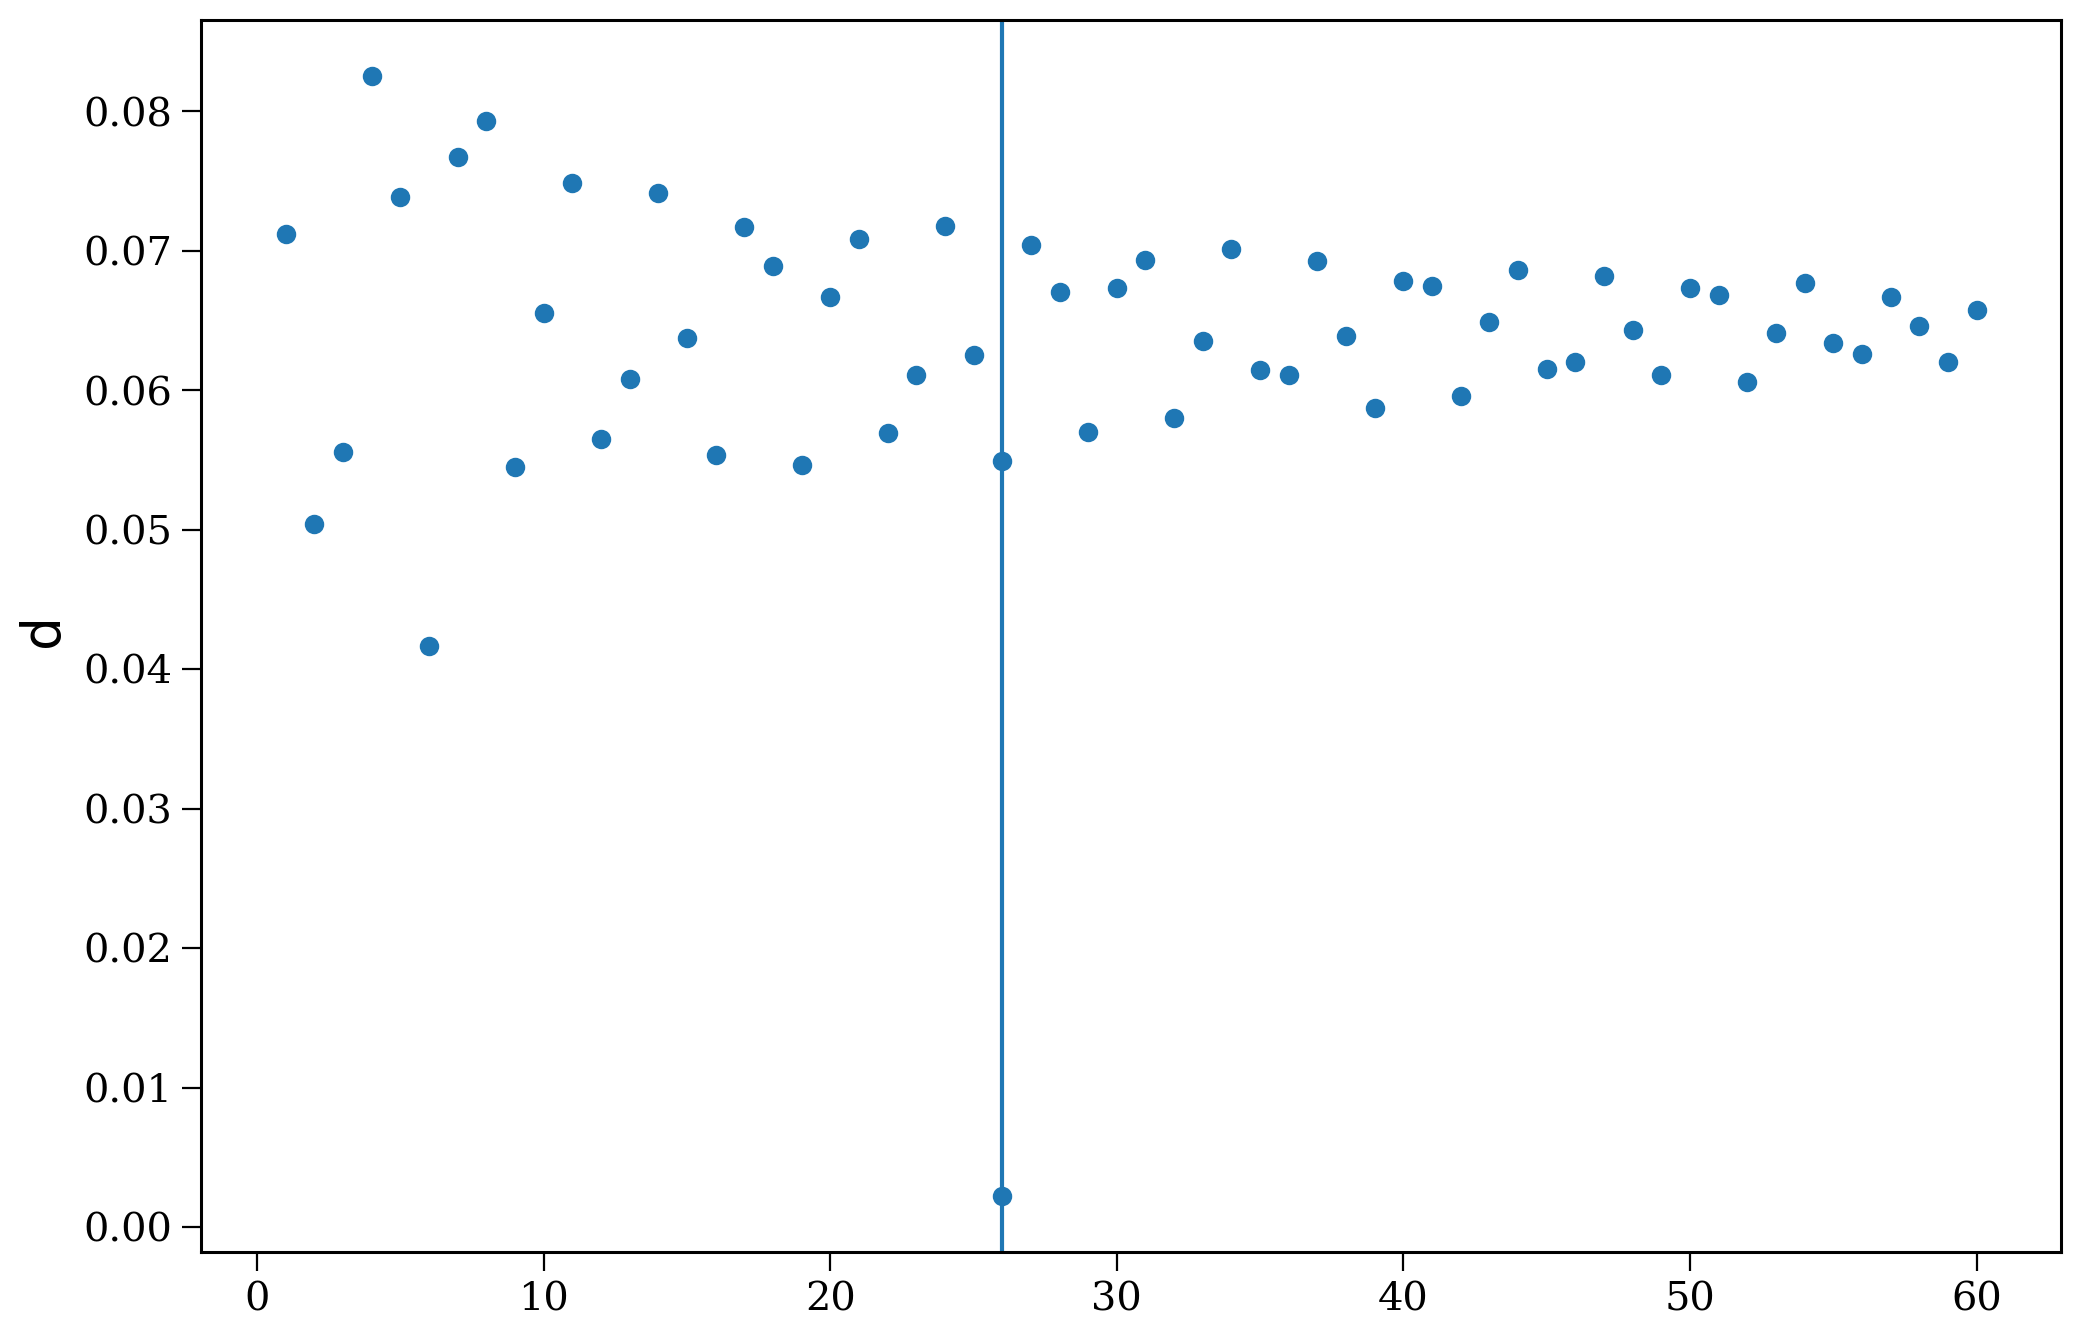

In [200]:
plt.scatter(ng[1:], delta_p)
plt.axvline(26)

In [168]:
ng

array([61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45,
       44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28,
       27, 26, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12,
       11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [66]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

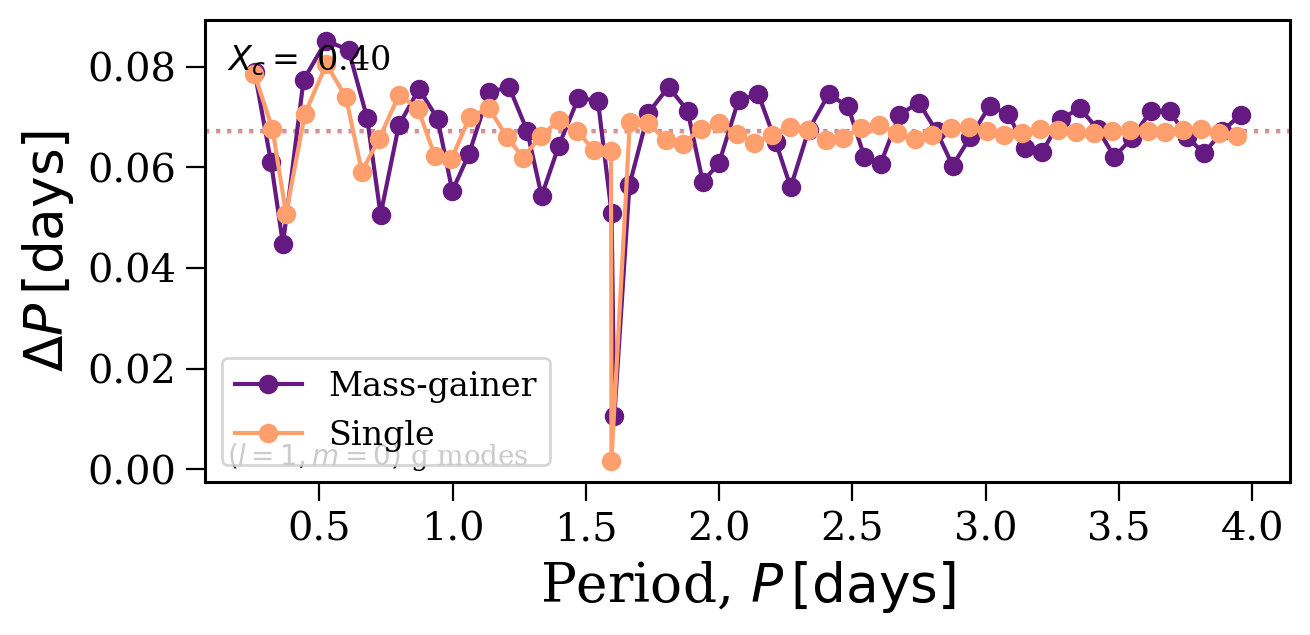

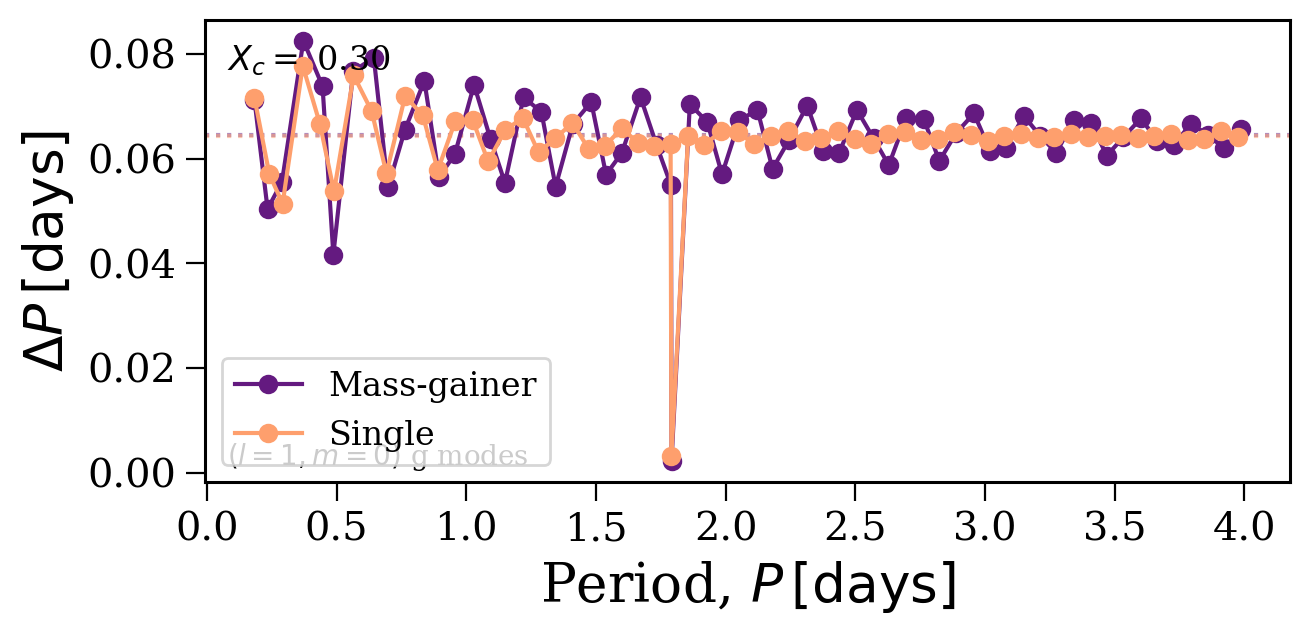

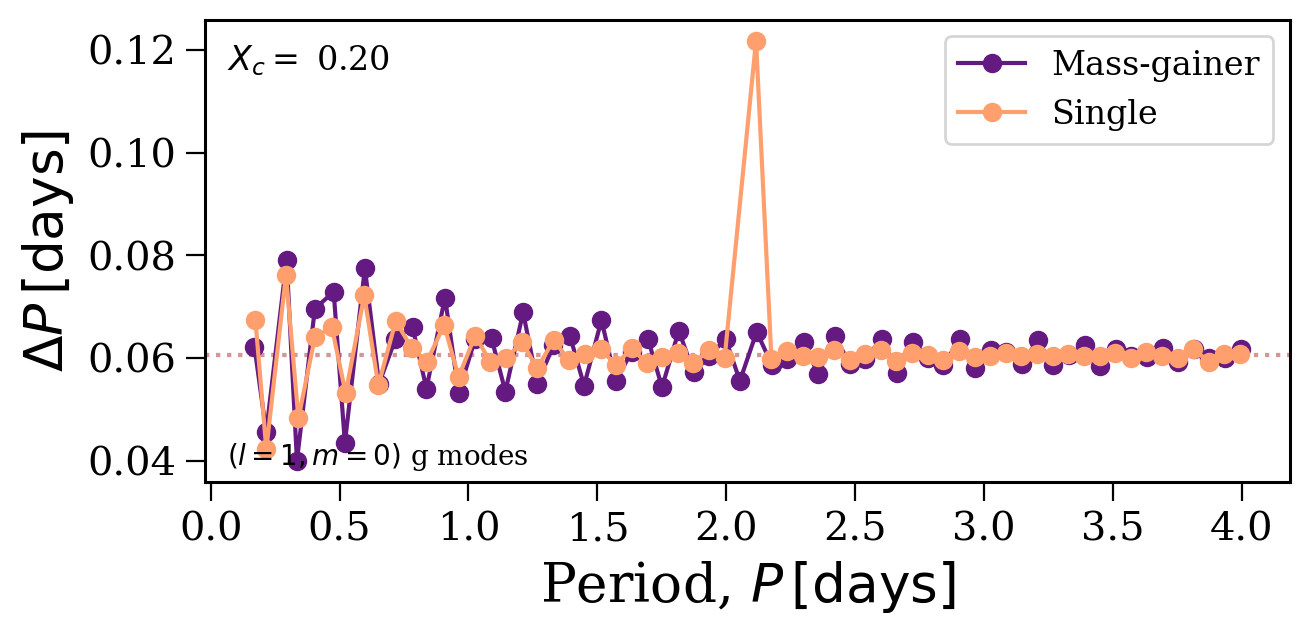

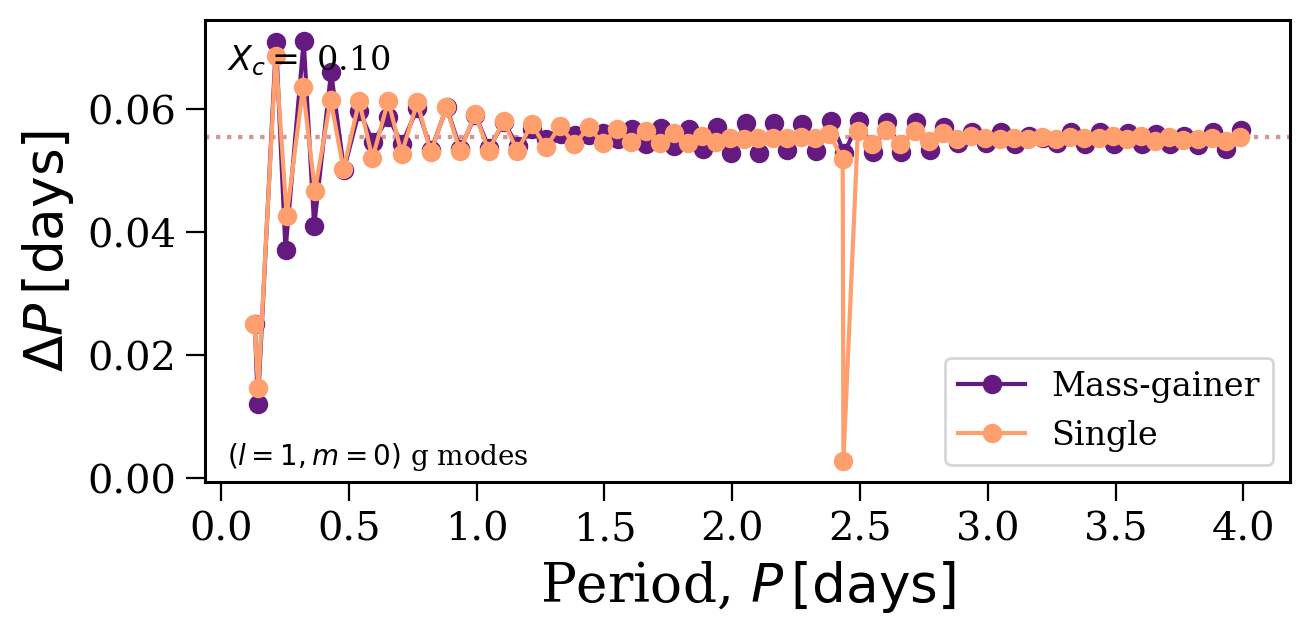

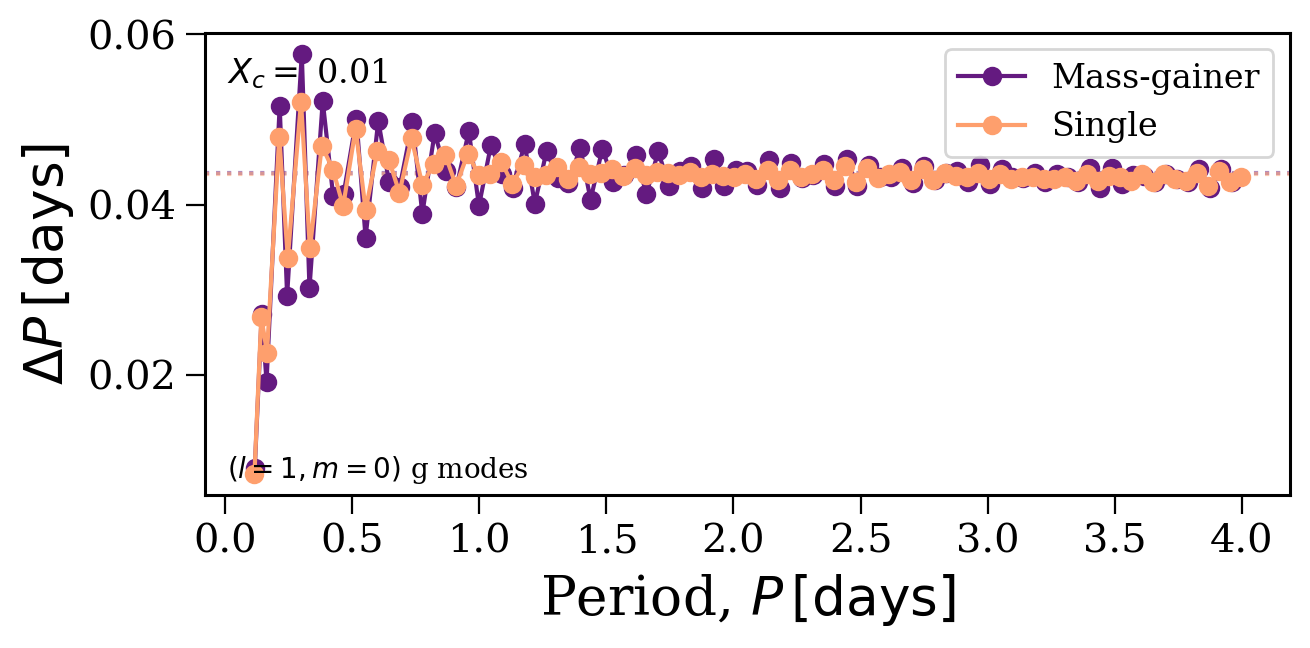

In [25]:
for X_c in [0.4, 0.3, 0.2, 0.1, 0.01]:
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], legend_loc="best", label_modes=False)

In [80]:
_, ng, _ = mpt.get_delta_p(D_mix_tracks["D_20"][1], X_c=0.4)

In [81]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

In [84]:
ng

array([58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42,
       41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25,
       24, 23, 22, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3])

In [90]:
_, inds = np.unique(ng, return_index=True)
np.asarray(sorted(inds))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [104]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

In [101]:
len()

array([58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42,
       41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25,
       24, 23, 22, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,
        8,  7,  6,  5,  4,  3])

In [130]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

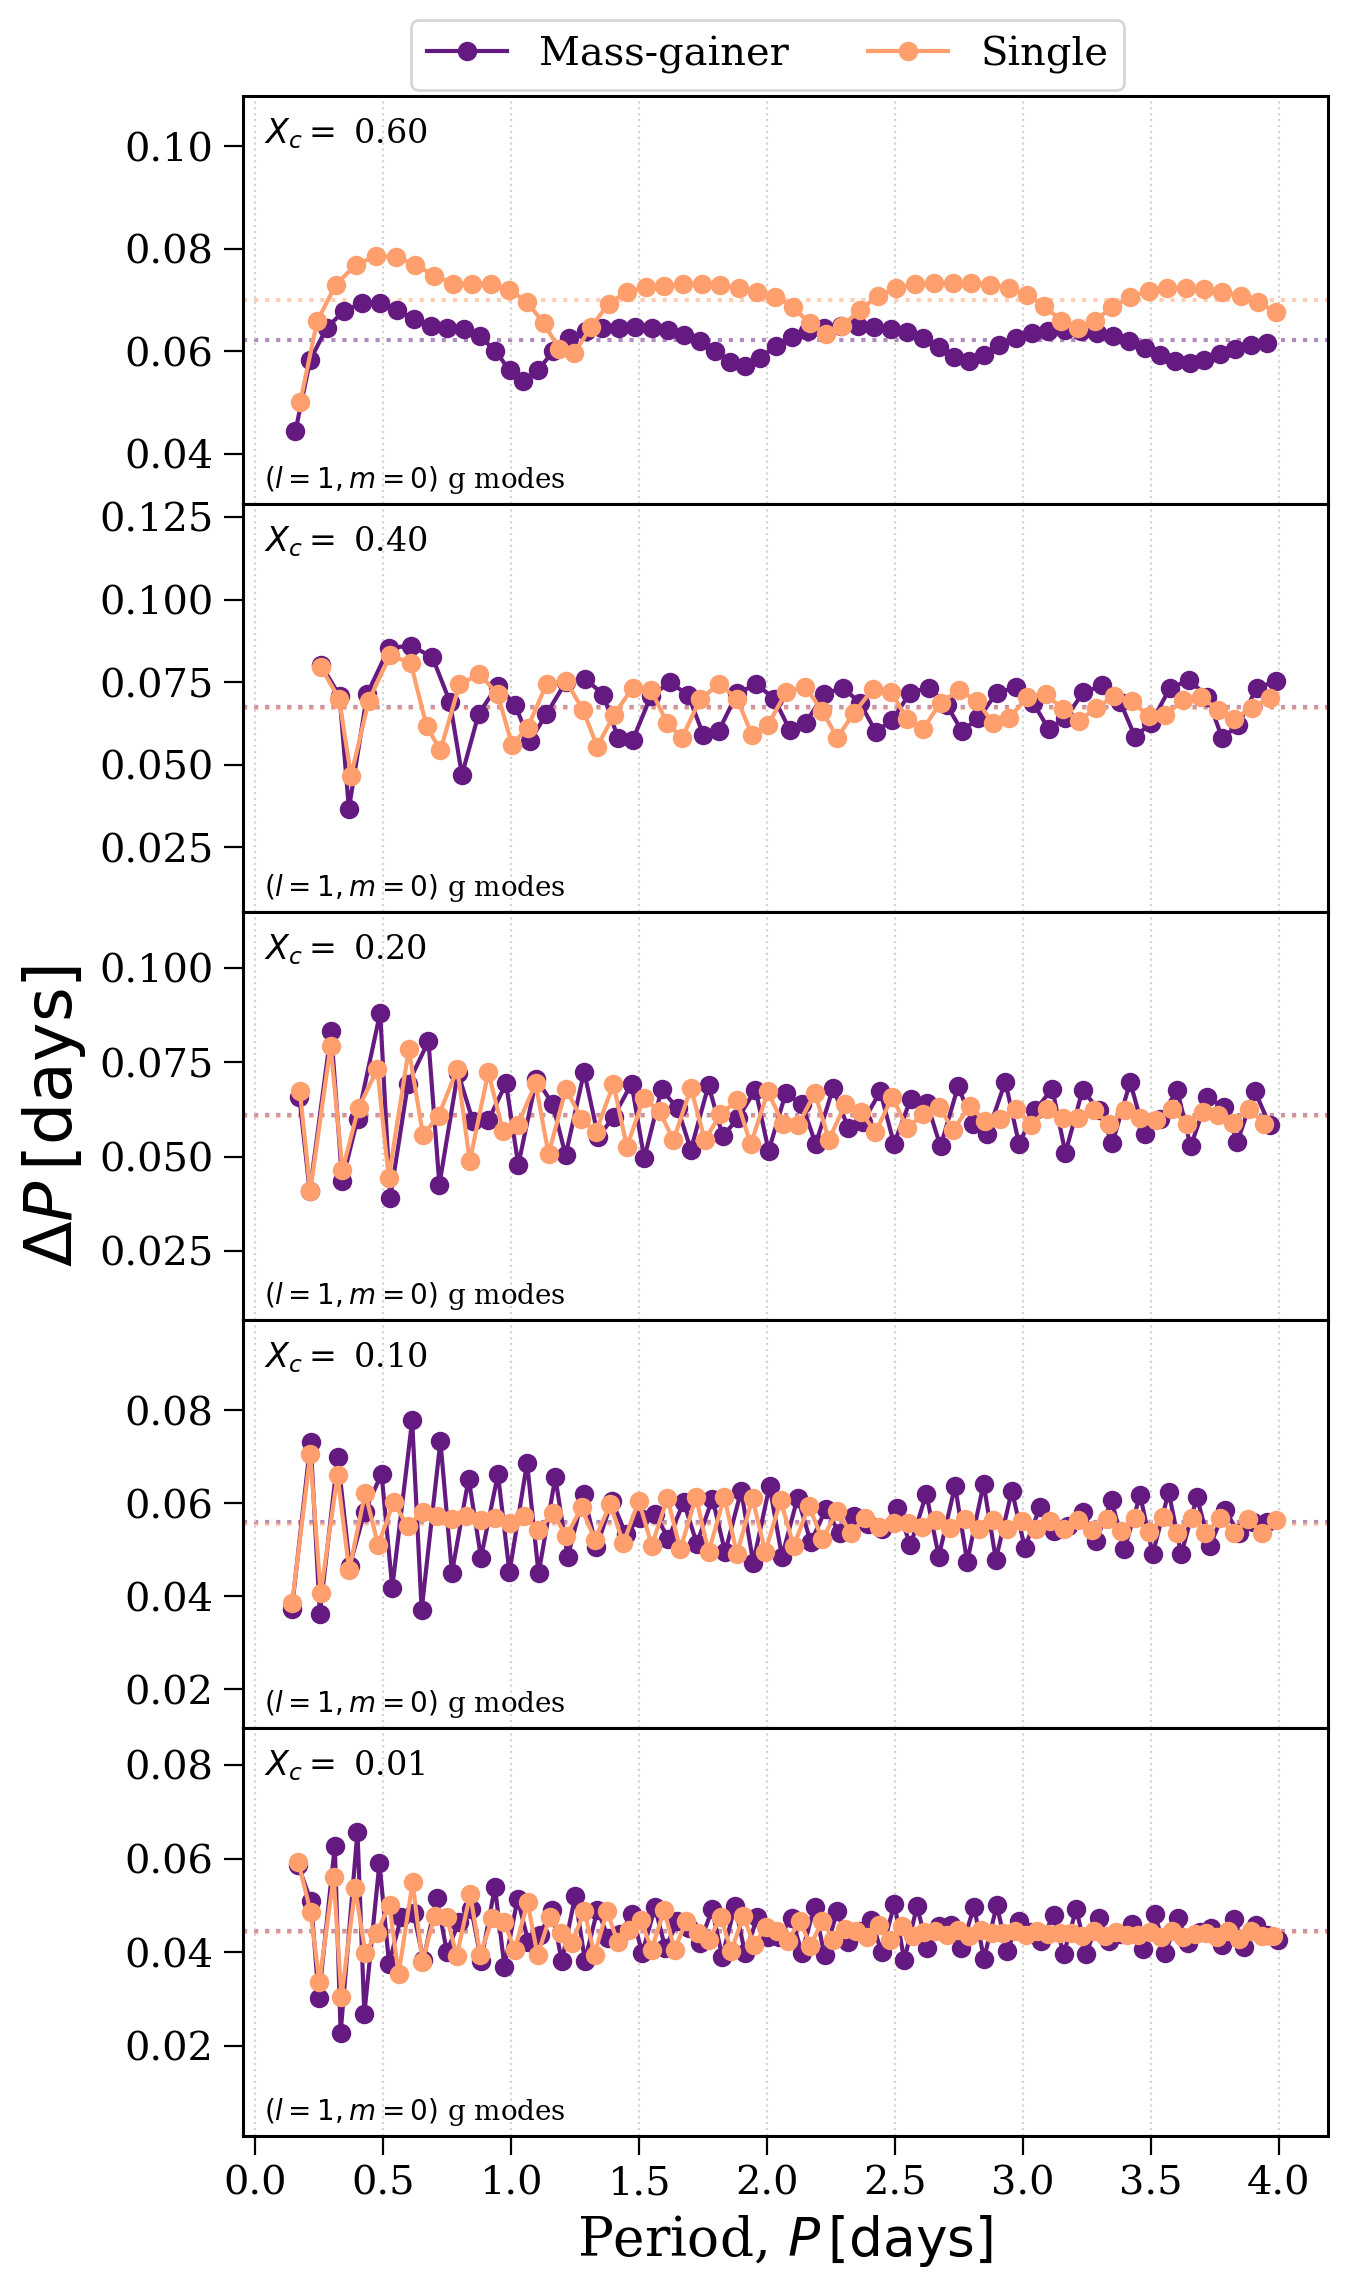

In [214]:
fig, axes = plt.subplots(5, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip([0.6, 0.4, 0.2, 0.1, 0.01], axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[D_mix_tracks["D_20"][1], single_tracks_mdm20["M_3.5"]],
                            legend_loc="lower right", label_modes=False, fig=fig, ax=ax, show=False, divide_delta_n=True, ylims="auto")
    
for ax in axes:
    ax.grid(axis='x', linestyle="dotted", color="lightgrey")
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.yaxis.label.set_fontsize(fs)
    else:
        ax.set_ylabel("")

fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0))

fig.subplots_adjust(hspace=0.0, top=0.96)

plt.savefig("figures/period_spacing_mdm20.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [196]:
single_tracks["M_3.5"]._freqs = None

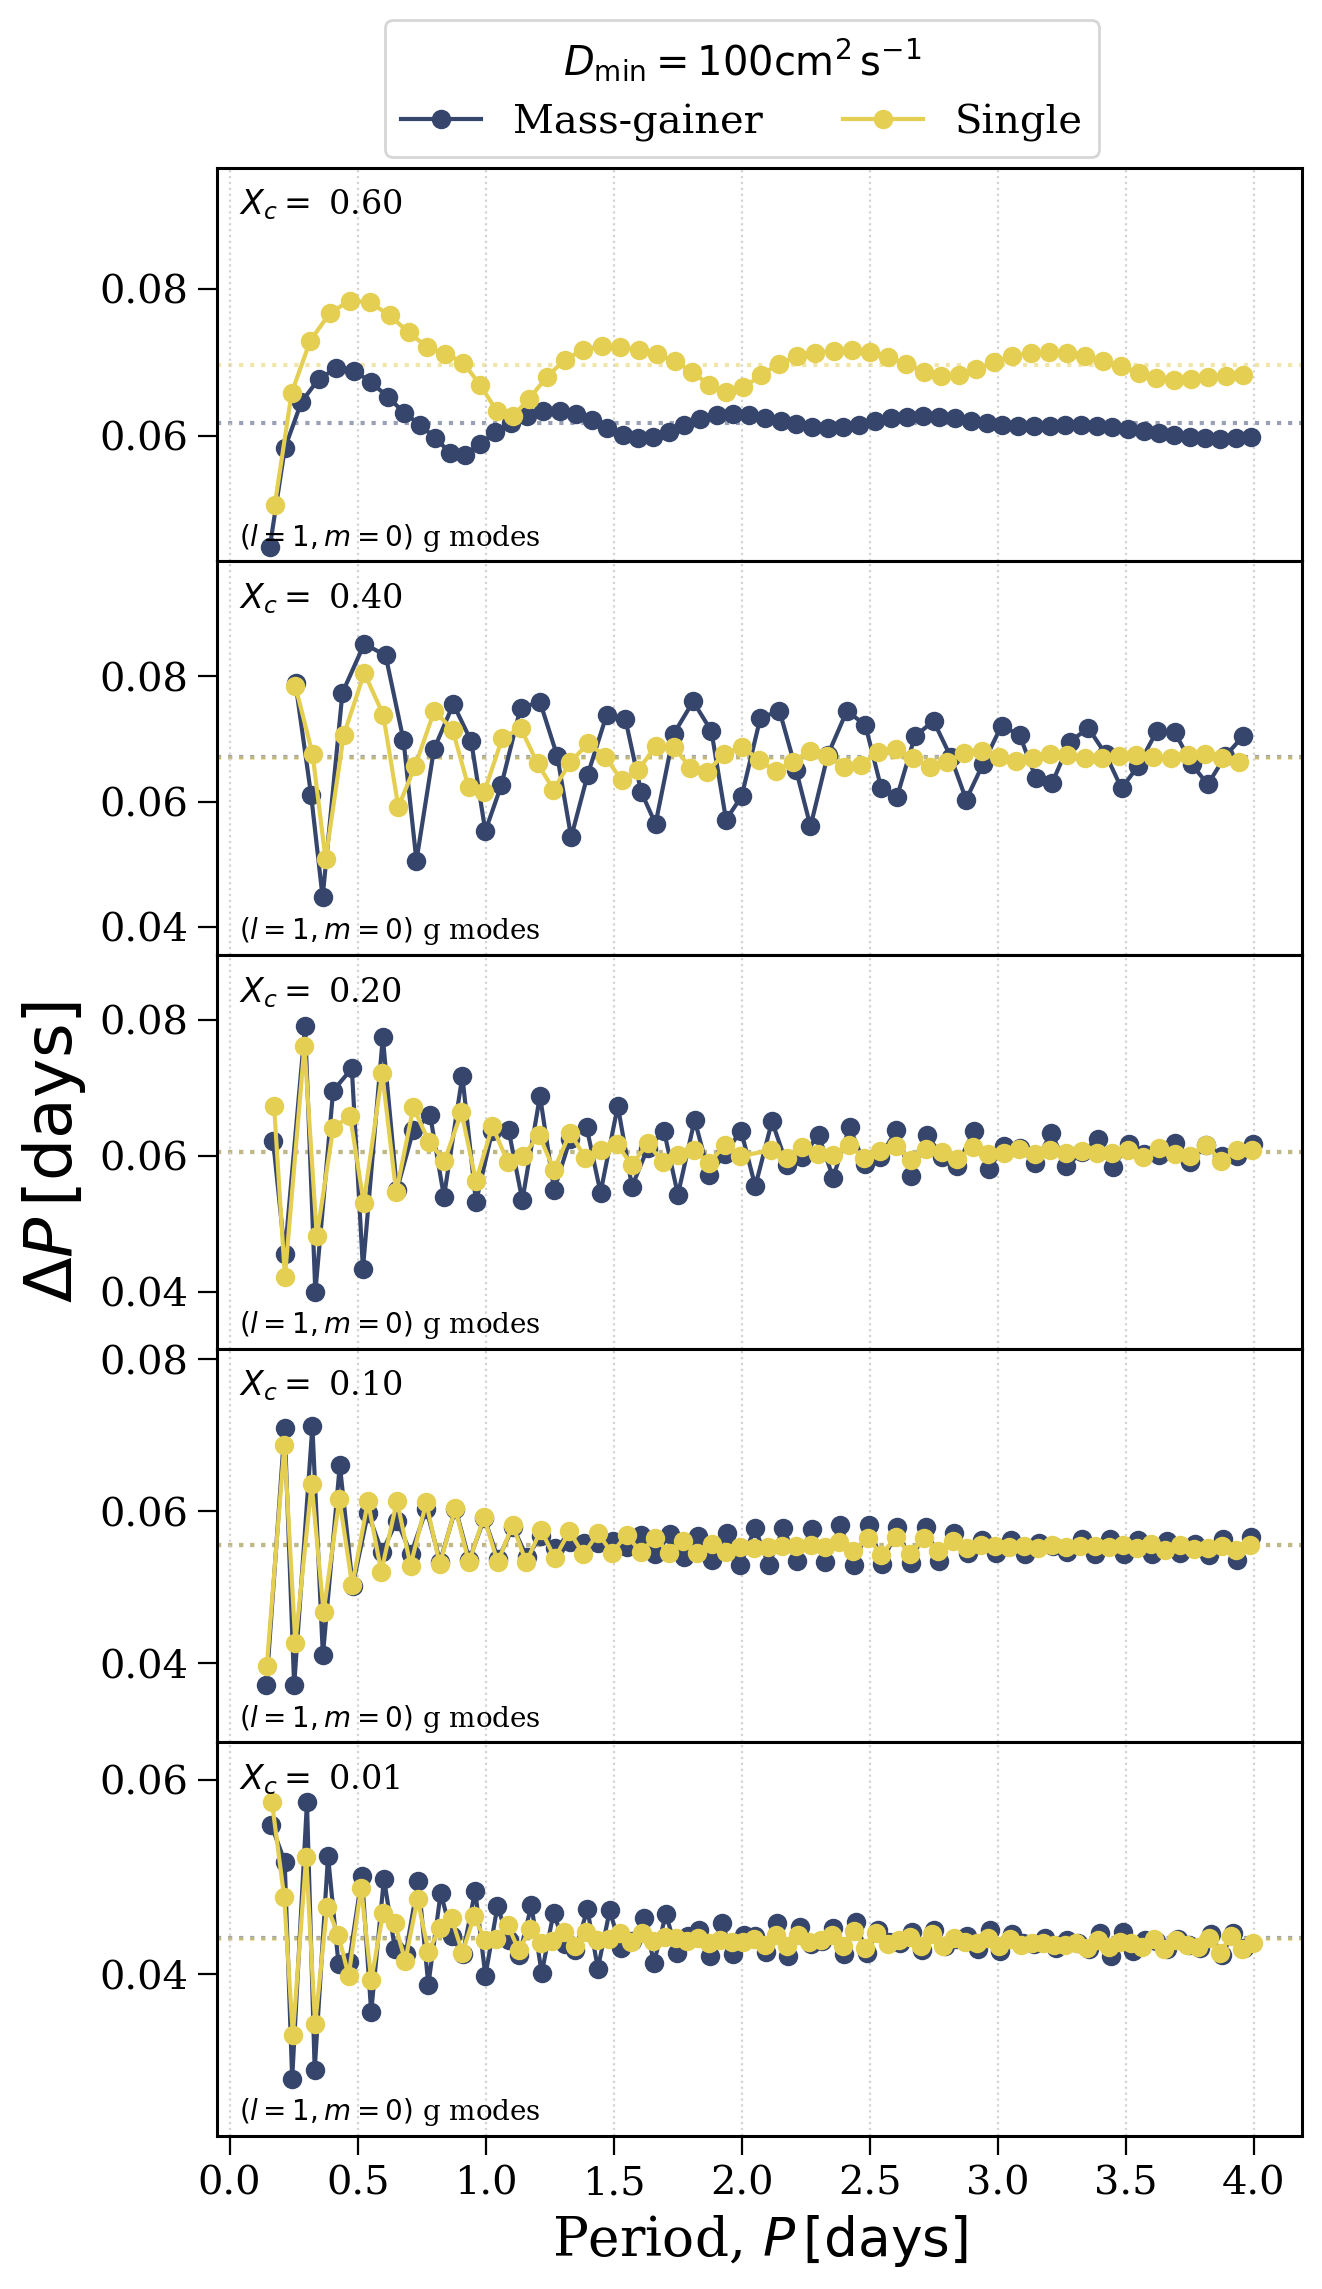

In [213]:
fig, axes = plt.subplots(5, 1, figsize=(7, 12), sharex=True)

for X_c, ax in zip([0.6, 0.4, 0.2, 0.1, 0.01], axes):
    mpt.plot_period_spacing(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]],
                            colours=[plt.get_cmap("cividis")(0.2), plt.get_cmap("cividis")(0.9)],
                            labels=["Mass-gainer", "Single"],
                            legend_loc="lower right", label_modes=False, fig=fig, ax=ax, show=False,
                            divide_delta_n=True, ylims="auto", ylim_auto_fac=1.4)
    # mpt.plot_period_spacing(X_c=X_c, tracks=[D_mix_tracks["D_20"][1], single_tracks_mdm20["M_3.5"]],
    #                         legend_loc="lower right", label_modes=False, fig=fig, ax=ax, show=False, divide_delta_n=True, ylims="auto")
    
for ax in axes:
    ax.grid(axis='x', linestyle="dotted", color="lightgrey")
    ax.get_legend().remove()
    if ax != axes[-1]:
        ax.set_xlabel("")
    if ax == axes[2]:
        ax.yaxis.label.set_fontsize(fs)
    else:
        ax.set_ylabel("")

leg = fig.legend(*ax.get_legend_handles_labels(), ncol=2, loc="upper center", bbox_to_anchor=(0.5, 1, 0, 0),
                 title=r"$D_{\rm min} = 100 {\rm cm^{2} \, s^{-1}}$")
plt.setp(leg.get_title(),fontsize=0.6*fs)

fig.subplots_adjust(hspace=0.0, top=0.93)

plt.savefig("figures/period_spacing_mdm100.pdf", format="pdf", bbox_inches="tight")

plt.show()

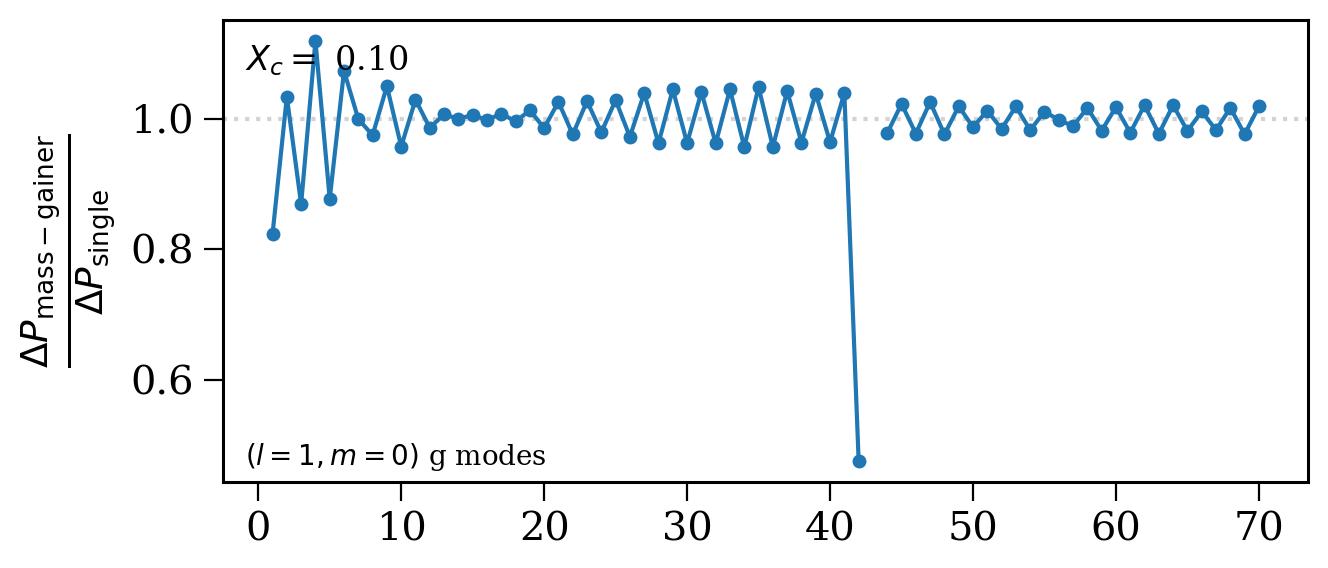

(<Figure size 700x300 with 1 Axes>,
 <Axes: ylabel='$\\frac{\\Delta P_{\\rm mass-gainer}}{\\Delta P_{\\rm single}}$'>)

In [241]:
def plot_period_spacing_ratio(age=None, X_c=None, tracks=None, legend_loc="upper left", label_with="an",
                        x_var="period", label_modes=False, xlims=None, ylims=None, divide_delta_n=False,
                        fig=None, ax=None, show=True):
    if age is None and X_c is None:
        raise ValueError("At least one of `age` or `X_c` must not be None")
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))
    plt.cla()
    
    delta_p = [None, None]
    ng = [None, None]
    for i, track in enumerate(tracks):
        mod = mpt.find_closest_model_number(track=track, age=age, X_c=X_c)

        
        df = track.freqs[mod - 1]
        df = df[(df["l"] == 1) & (df["m"] == 0)]# & (df["n_p"] == 0)]
        mixed_modes = df[df["n_p"] > 0]
        duplicates = df[df["n_g"].isin(mixed_modes["n_g"])]
        drop_these = duplicates[duplicates["n_p"] == 0].index

        df = df.drop(index=drop_these)
                
        periods = 1 / df["Re(freq)"].values * u.day
        ng[i] = df["n_g"].values
        delta_p[i] = np.concatenate(([np.nan], periods[:-1] - periods[1:]))

    # print(np.min(ng), np.max(ng))
    n_g_range = np.arange(min(min(ng[0]), min(ng[1])), max(max(ng[0]), max(ng[1])))
    numerator = [delta_p[0][ng[0] == n] for n in n_g_range]
    denominator = [delta_p[1][ng[1] == n] for n in n_g_range]
    ratios = [(numerator[i][0] / denominator[i][0] if len(numerator[i]) > 0 and len(denominator[i]) > 0 else np.nan) for i in range(len(numerator))]

    ax.plot(n_g_range, ratios, marker="o", markersize=4)
    ax.axhline(1.0, linestyle="dotted", color="lightgrey", zorder=-1)

    # ax.set_xlabel(r"Period, $P \, [\rm days]$" if x_var == "period" else r"$k$ (g-modes)")
    ax.set_ylabel(r"$\frac{\Delta P_{\rm mass-gainer}}{\Delta P_{\rm single}}$")

    # ax.set_title(f"\nAge = {age:1.1f} Myr, X_c = {X_c:1.2f}", fontsize=0.6*fs)
    
    if label_with == "title":
        ax.set_title(r"Period spacing for final mass ~3.5 $\rm M_{\odot}$ star"\
                     + (f' at {age:1.1f} Myr' if X_c is None else r" with $X_c =$" + f' {X_c:1.2f}'))
    else:
        ax.annotate(f'Age = {age:1.1f} Myr' if X_c is None else r"$X_c =$" + f' {X_c:1.2f}',
                    xy=(0.02, 0.95), xycoords="axes fraction", va="top", fontsize=0.5*fs)

    ax.annotate(r"$(l = 1, m = 0)$ g modes", xy=(0.02, 0.02), xycoords="axes fraction", va="bottom")

    if ylims is not None:
        ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)
    
    if show:
        plt.show()

    return fig, ax

plot_period_spacing_ratio(X_c=0.1, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]])

In [62]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

In [85]:
from 

In [166]:
interp_delta_p - asym

array([ 0.01258836,  0.01258231,  0.01257627, ..., -0.00123076,
       -0.00123112, -0.00123149])

Parsing $m_1 = 4, m_2 = 3 {\rm M_\odot}$, $P = 5 \, {\rm days}, D_{\rm min} = 100 \, {\rm cm^2 \, s^{-1}}$ (Accretor)


100%|██████████| 1047/1047 [00:04<00:00, 246.70it/s]


NameError: name 'interp1d' is not defined

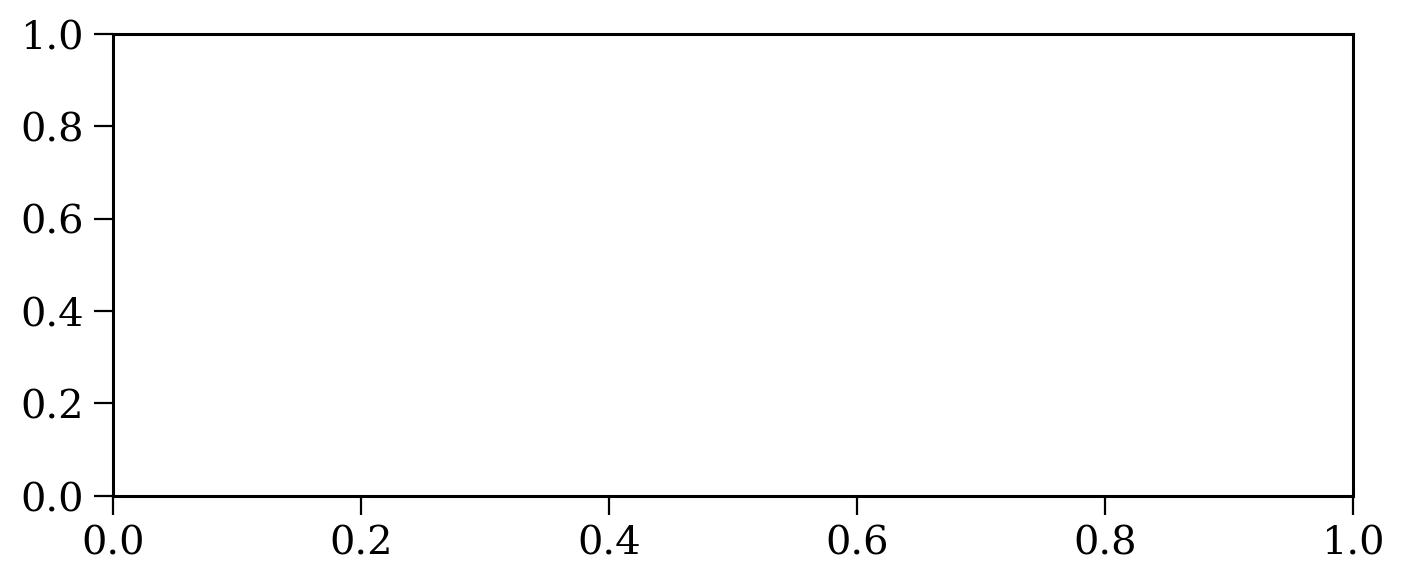

In [11]:
fig, ax = plt.subplots(figsize=(8, 3))

for track, col in zip([tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], [mpt.mass_gainer_col, mpt.single_col]):
    periods, ng, delta_p = mpt.get_delta_p(track=track, X_c=0.4)
    asym = mpt.asymptotic_period_spacing(track.profiles[mpt.find_closest_model_number(track=track, X_c=0.4) - 1]).value
    x = interp1d(periods, delta_p, fill_value="extrapolate")

    p_range = np.linspace(0.25, 4, 100000)
    interp_delta_p = x(p_range)
    crossing = np.where(np.diff(np.sign(interp_delta_p - asym)))[0]

    area_under = np.trapz(y=np.abs(interp_delta_p - asym), x=p_range)
    print(f'Area under the curve is {area_under:1.1e}')

    plt.plot(p_range, interp_delta_p, color=col)
    plt.fill_between(p_range, asym, interp_delta_p, color=col, alpha=0.2)
    plt.scatter(p_range[crossing], interp_delta_p[crossing], color=col)

plt.xlabel("Period")
plt.ylabel("Period spacing", fontsize=0.5*fs)
plt.ylim(-0.025 + asym, 0.025 + asym)

In [173]:
n = np.repeat(3, len(crossing))
n[0], n[-1] = 2, 2

In [179]:
for i in range(1, len(crossing)):
    print(p_range[crossing][i] - p_range[crossing][i - 1])

0.1064260642606426
0.19537695376953768
0.10743857438574389
0.16638916389163882
0.13732637326373265
0.15386403864038645
0.15337653376533766
0.1252512525125251
0.19151441514415146
0.10668856688566875
0.14625146251462517
0.14287642876428763
0.16188911889118884
0.1271637716377163
0.1539015390153904
0.1653391533915336
0.1612891128911289
0.19717697176971782
0.1175636756367564
0.2373773737737377
0.03585035850358498
0.45746707467074677


In [191]:
total_dists = np.concatenate(([diff[0]], [diff[i] + diff[i + 1] for i in range(len(diff) - 1)], [diff[-1]]))
total_dists / n

array([0.05321303, 0.10060101, 0.10093851, 0.09127591, 0.10123851,
       0.09706347, 0.10241352, 0.09287593, 0.10558856, 0.09940099,
       0.08431334, 0.09637596, 0.10158852, 0.09635096, 0.09368844,
       0.10641356, 0.10887609, 0.11948869, 0.10491355, 0.11831368,
       0.09107591, 0.16443914, 0.22873354])

In [188]:
diff = np.diff(p_range[crossing])

In [174]:
p_range[crossing][1:] - p_range[crossing][:-1]

array([0.10642606, 0.19537695, 0.10743857, 0.16638916, 0.13732637,
       0.15386404, 0.15337653, 0.12525125, 0.19151442, 0.10668857,
       0.14625146, 0.14287643, 0.16188912, 0.12716377, 0.15390154,
       0.16533915, 0.16128911, 0.19717697, 0.11756368, 0.23737737,
       0.03585036, 0.45746707])

In [170]:
p_range[crossing]

array([0.32593826, 0.43236432, 0.62774128, 0.73517985, 0.90156902,
       1.03889539, 1.19275943, 1.34613596, 1.47138721, 1.66290163,
       1.7695902 , 1.91584166, 2.05871809, 2.22060721, 2.34777098,
       2.50167252, 2.66701167, 2.82830078, 3.02547775, 3.14304143,
       3.3804188 , 3.41626916, 3.87373624])

In [130]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

In [20]:
10**(tracks["4_3_5_mdm100"][1].history.loc[mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=0.4) - 1]["log_R"])

3.0850411982928647

In [21]:
10**(single_tracks["M_3.5"].history.loc[mpt.find_closest_model_number(single_tracks["M_3.5"], X_c=0.4) - 1]["log_R"])

3.070371833854657

In [136]:
np.correlate(p_range[crossing], p_range[crossing], mode='full')

array([  1.1558875 ,   2.73106817,   5.28523678,   8.15483979,
        11.51504164,  15.26127777,  19.57827   ,  24.25074403,
        29.23843663,  34.60374038,  40.40343288,  46.45607613,
        52.81489303,  59.3750869 ,  66.26416919,  73.30689399,
        80.57238674,  87.95367254,  95.4979126 , 103.10785428,
       110.86380071, 118.66033257, 126.55144011, 134.44002049,
       126.55144011, 118.66033257, 110.86380071, 103.10785428,
        95.4979126 ,  87.95367254,  80.57238674,  73.30689399,
        66.26416919,  59.3750869 ,  52.81489303,  46.45607613,
        40.40343288,  34.60374038,  29.23843663,  24.25074403,
        19.57827   ,  15.26127777,  11.51504164,   8.15483979,
         5.28523678,   2.73106817,   1.1558875 ])

In [123]:
interp_delta_p[crossing].max()

9.263600050869042e-06

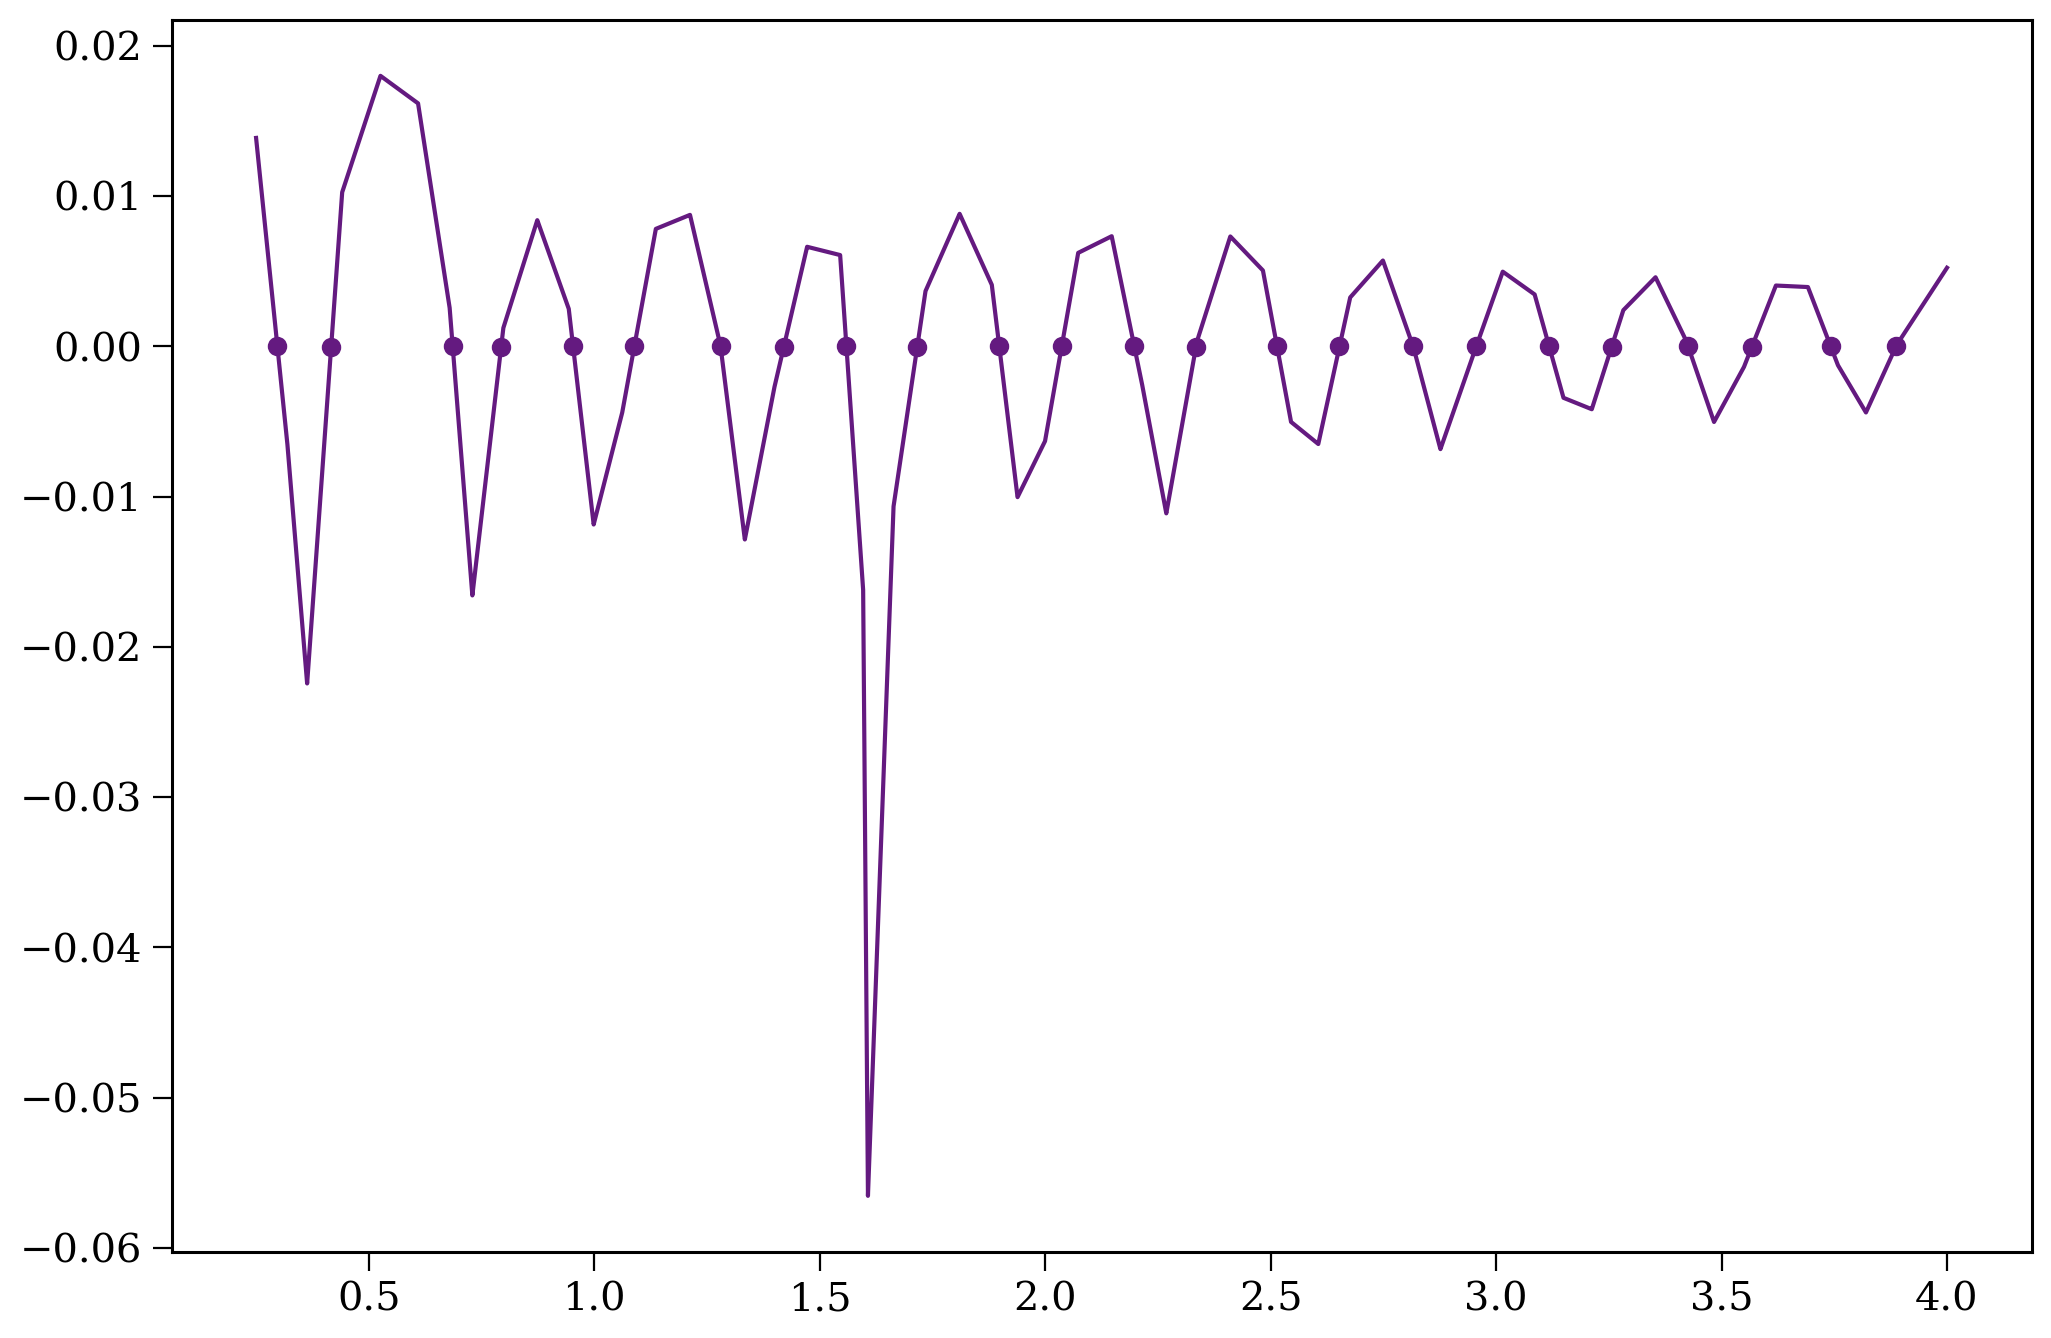

(0.02, 0.08)

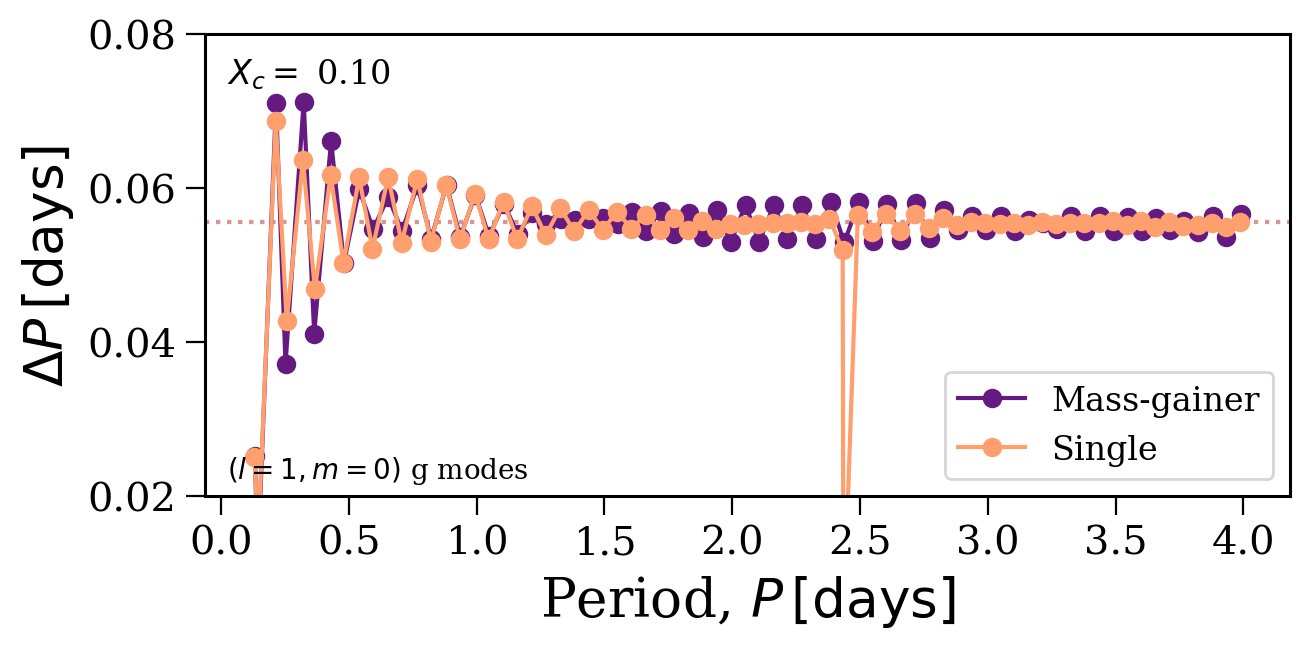

In [69]:
fig, ax, _, _ = mpt.plot_period_spacing(X_c=0.1, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]],
                                        legend_loc="lower right", show=False, label_modes=False)
ax.set_ylim(0.02, 0.08)

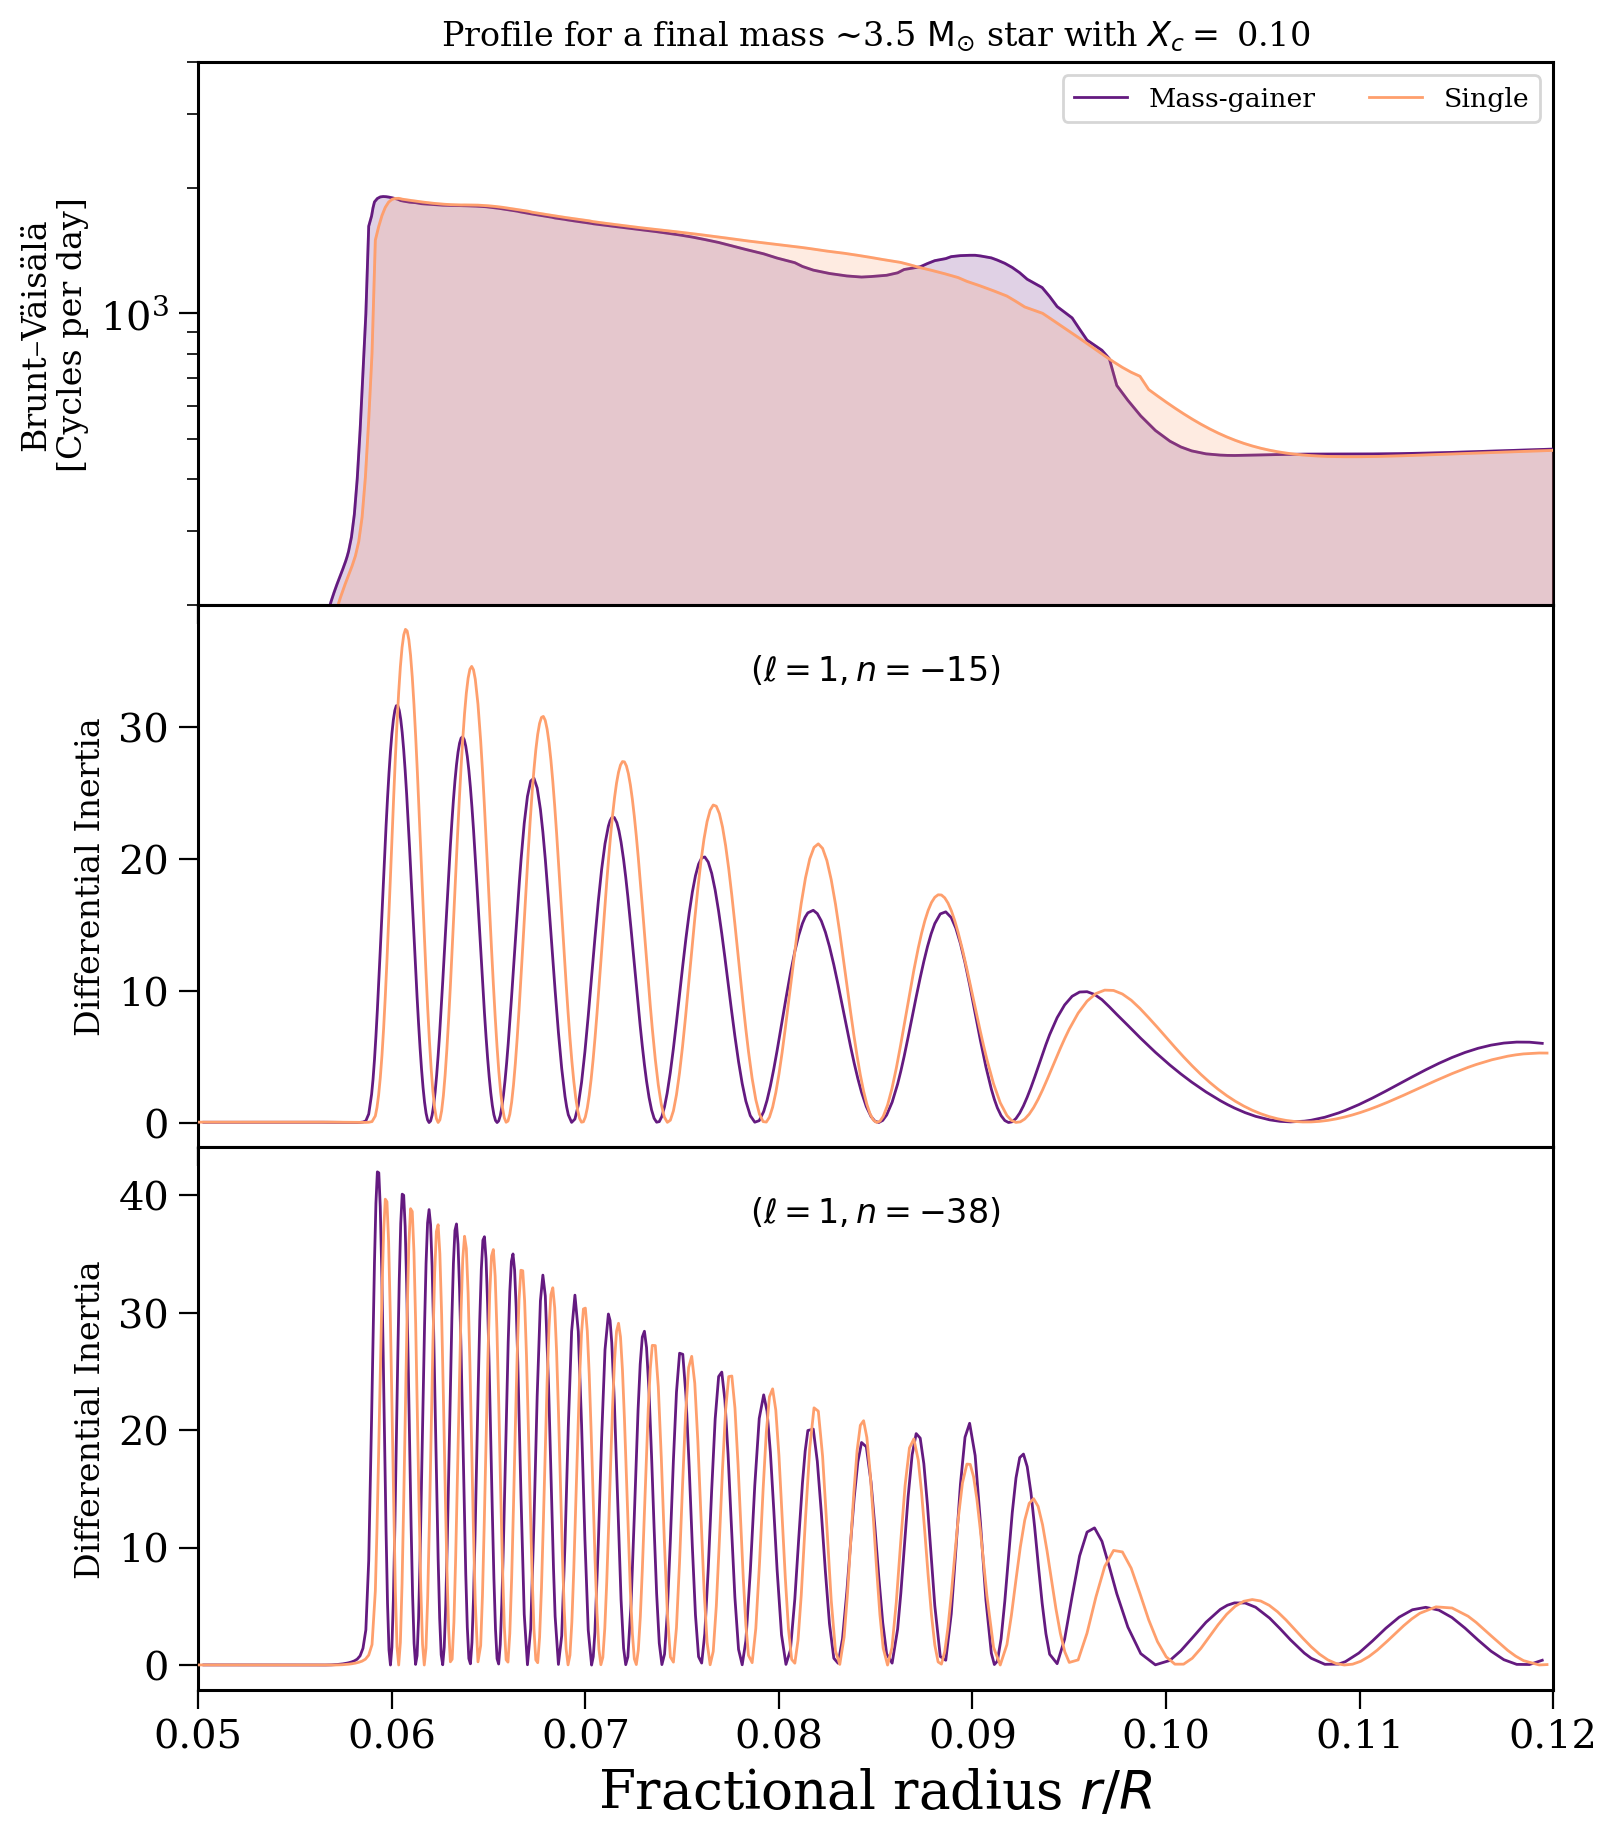

In [111]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

X_c = 0.1
x_range = (0.05, 0.12)

mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], fractional_radius=True,
                    fig=fig, ax=axes[0], show=False)
axes[0].set_xlim(x_range)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], which="enorm", sph_deg=1, rad_ord=[-15],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], which="enorm", sph_deg=1, rad_ord=[-38],
              X_c=X_c, fig=fig, ax=axes[2], x_range=x_range, show=False, plot_core=False)

fig.subplots_adjust(hspace=0.0)

for ax in axes[:-1]:
    ax.set_xlabel("")

axes[0].set_ylim(2e2, 4e3)

plt.show()

In [61]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

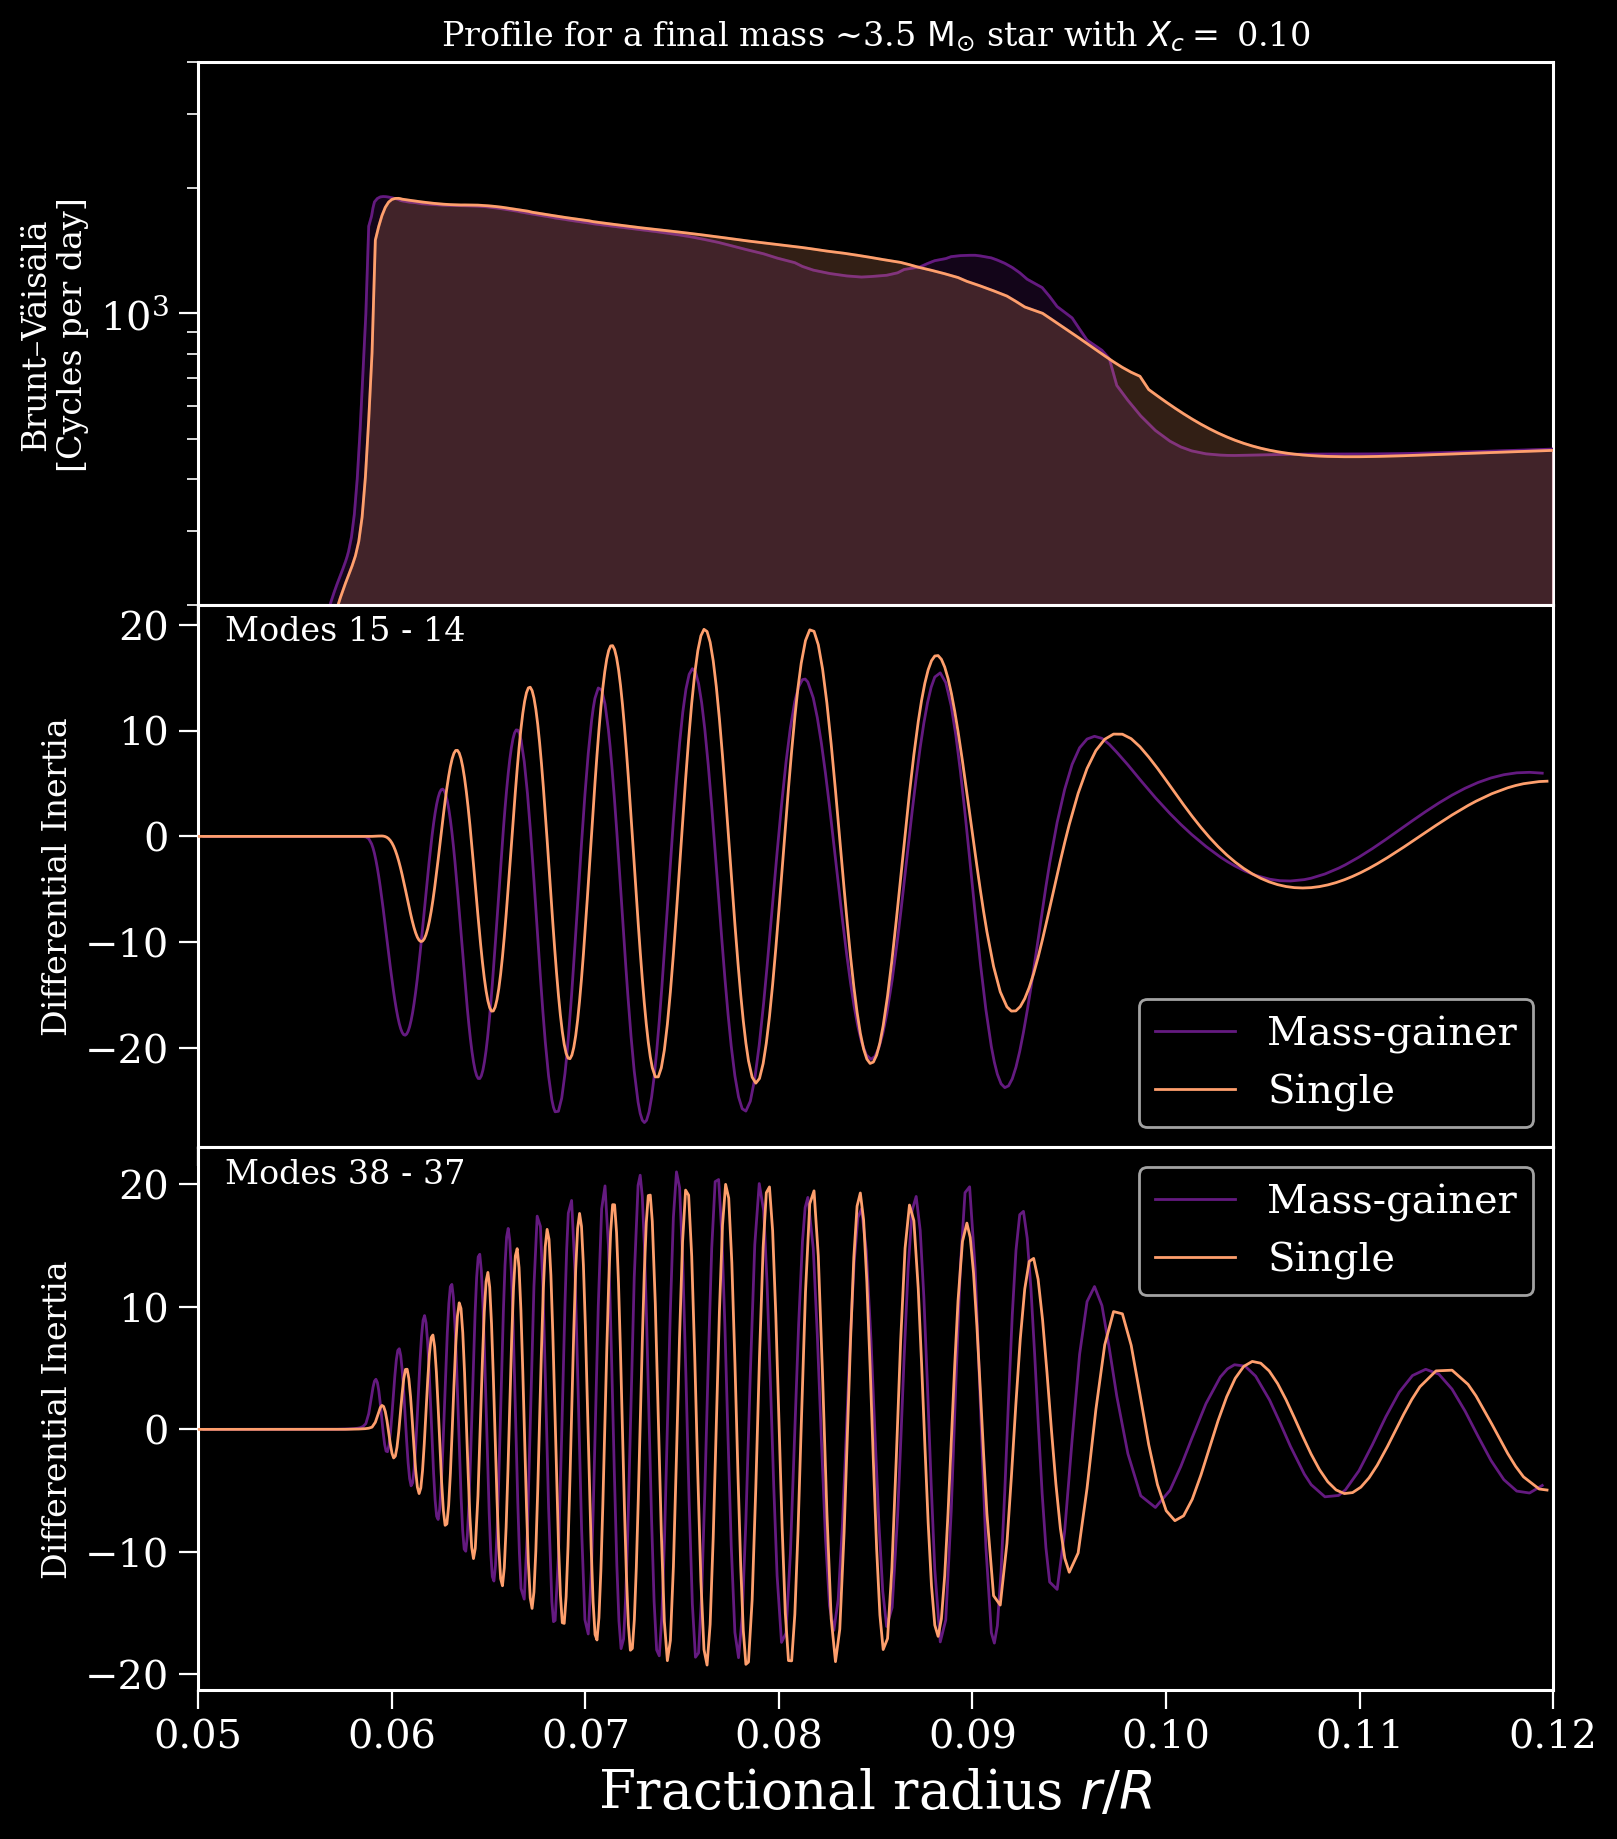

In [104]:
fig, axes = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

X_c = 0.1
x_range = (0.05, 0.12)

which = "enorm"

mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], fractional_radius=True,
                    fig=fig, ax=axes[0], show=False)
axes[0].set_xlim(x_range)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1]], which=which, sph_deg=1, rad_ord=[-14, -15],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False, difference=True)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1]], which=which, sph_deg=1, rad_ord=[-37, -38],
              X_c=X_c, fig=fig, ax=axes[2], x_range=x_range, show=False, plot_core=False, difference=True)
mpt.plot_eigs(tracks=[single_tracks["M_3.5"]], which=which, sph_deg=1, rad_ord=[-14, -15],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False,
              colours=[mpt.single_col, mpt.single_col], labels=["Single", "Single"], difference=True)
mpt.plot_eigs(tracks=[single_tracks["M_3.5"]], which=which, sph_deg=1, rad_ord=[-37, -38],
              X_c=X_c, fig=fig, ax=axes[2], x_range=x_range, show=False, plot_core=False,
              colours=[mpt.single_col, mpt.single_col], labels=["Single", "Single"], difference=True)

axes[1].annotate("Modes 15 - 14", xy=(0.02, 0.98), ha="left", va="top", xycoords="axes fraction", fontsize=0.5*fs)
axes[2].annotate("Modes 38 - 37", xy=(0.02, 0.98), ha="left", va="top", xycoords="axes fraction", fontsize=0.5*fs)

fig.subplots_adjust(hspace=0.0)

for ax in axes[:-1]:
    ax.set_xlabel("")

axes[0].set_ylim(2e2, 4e3)

plt.show()

In [328]:
create_GYRE_bash(mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=[0.4, 0.3, 0.2, 0.1, 0.01]))

"echo -n 'profile964.data.GYRE,profile980.data.GYRE,profile998.data.GYRE,profile1016.data.GYRE,profile1034.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"

In [73]:
reload(mpt)

<module 'mesaplot_tom' from '/afs/mpa/temp/tomwagg/kavli/notebooks/../helpers/mesaplot_tom.py'>

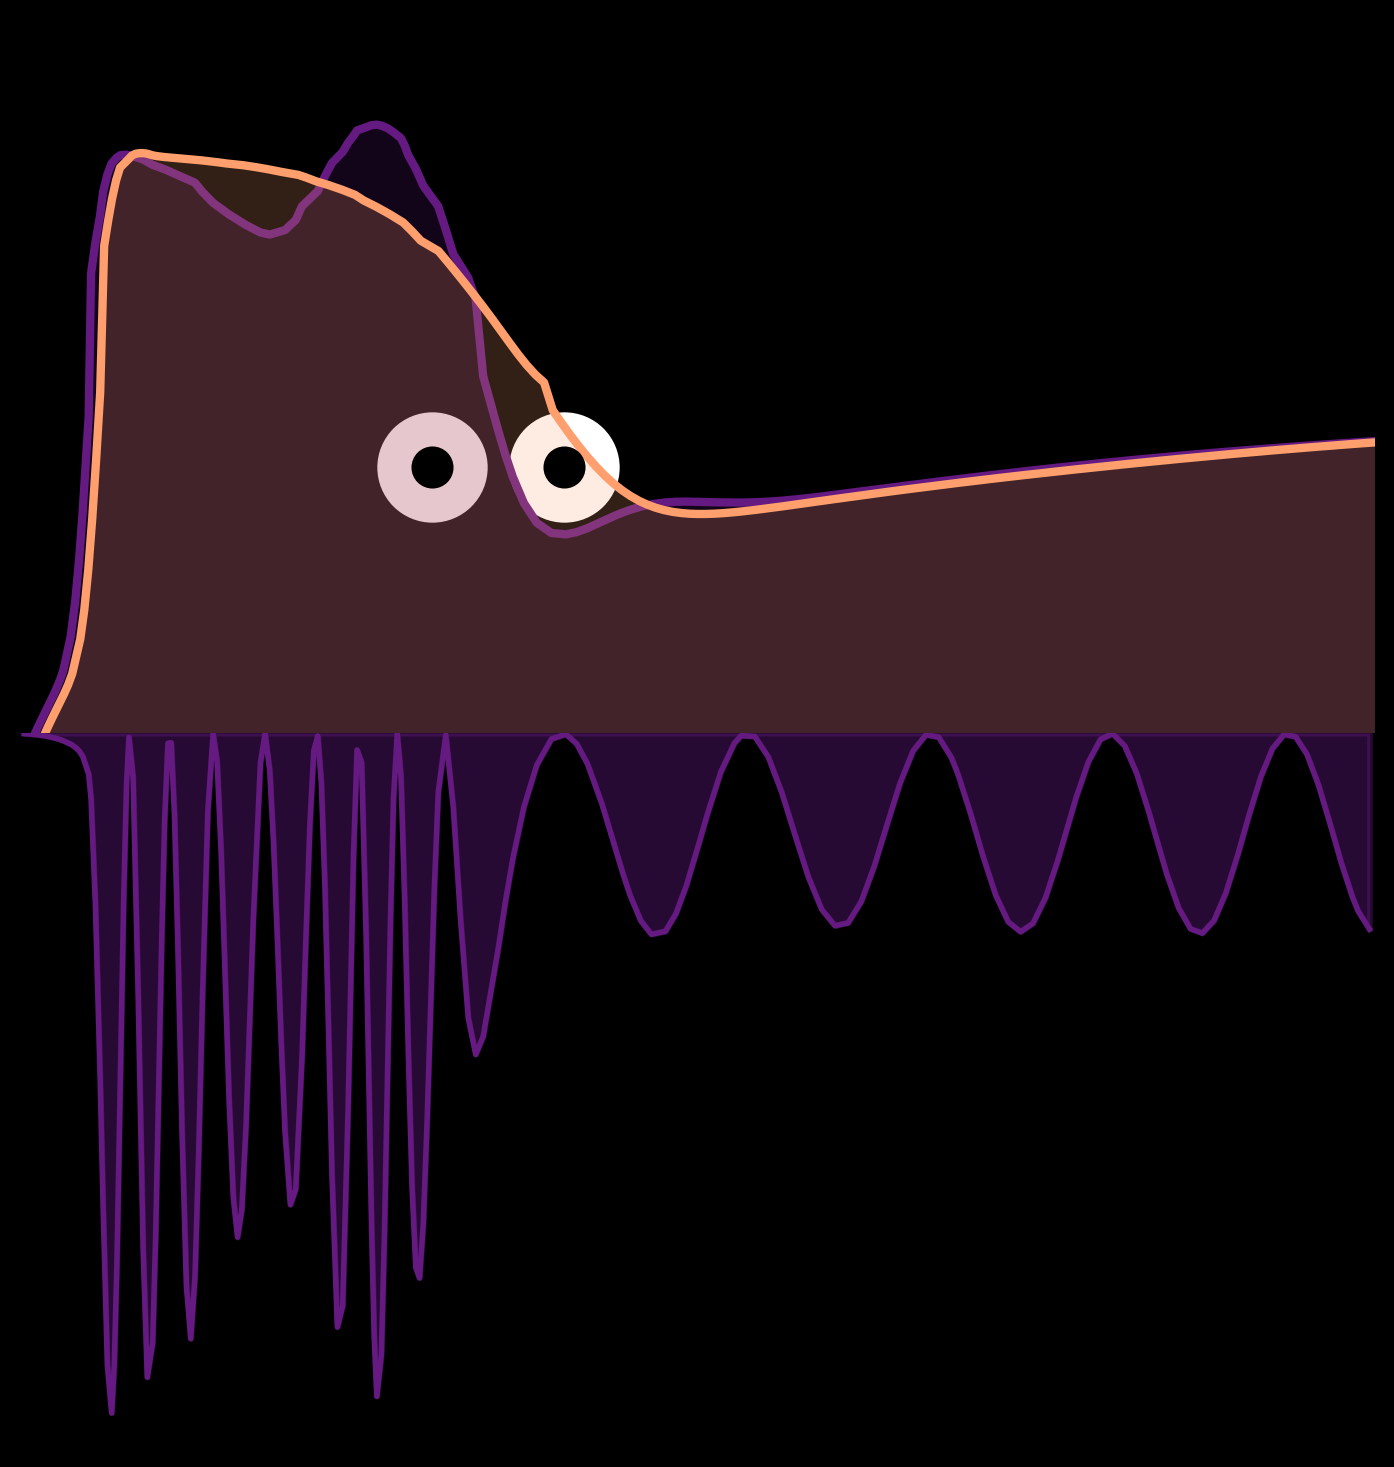

In [103]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

X_c = 0.4
x_range = (0.108, 0.18)

mpt.plot_BV_profile(X_c=X_c, tracks=[tracks["4_3_5_mdm100"][1], single_tracks["M_3.5"]], fractional_radius=True,
                    fig=fig, ax=axes[0], show=False, lw=3)
axes[0].set_xlim(x_range)
mpt.plot_eigs(tracks=[tracks["4_3_5_mdm100"][1]], which="enorm", sph_deg=1, rad_ord=[-40],
              X_c=X_c, fig=fig, ax=axes[1], x_range=x_range, show=False, plot_core=False, lw=2)

fig.subplots_adjust(hspace=0.0)

for ax in axes[:-1]:
    ax.set_xlabel("")

axes[0].set_ylim(2e2, 3e3)
axes[0].set_title("")
axes[1].invert_yaxis()
axes[1].set_ylim(top=0.0)

for ax in axes:
    ax.axis("off")

def eyeball(x, y):
    axes[0].scatter(x, y, s=1500, color="white", zorder=3)
    axes[0].scatter(x, y, s=200, color="black", zorder=30)

eyeball(0.1369, 5.5e2)
eyeball(0.1299, 5.5e2)

plt.show()

In [137]:
create_GYRE_bash(mpt.find_closest_model_number(D_mix_tracks["D_20"][1], X_c=[0.6, 0.4, 0.2, 0.1, 0.01]))

"echo -n 'profile67.data.GYRE,profile964.data.GYRE,profile997.data.GYRE,profile1015.data.GYRE,profile1032.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"

In [140]:
create_GYRE_bash(mpt.find_closest_model_number(single_tracks_mdm20["M_3.5"], X_c=[0.6, 0.4, 0.2, 0.1, 0.01]))

"echo -n 'profile48.data.GYRE,profile76.data.GYRE,profile109.data.GYRE,profile127.data.GYRE,profile144.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"

In [189]:
create_GYRE_bash(mpt.find_closest_model_number(tracks["4_3_5_mdm100"][1], X_c=[0.6, 0.4, 0.2, 0.1, 0.01]))

"echo -n 'profile67.data.GYRE,profile964.data.GYRE,profile998.data.GYRE,profile1016.data.GYRE,profile1034.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"

In [194]:
create_GYRE_bash(mpt.find_closest_model_number(single_tracks["M_3.5"], X_c=[0.6, 0.4, 0.2, 0.1, 0.01]))

"echo -n 'profile48.data.GYRE,profile76.data.GYRE,profile109.data.GYRE,profile127.data.GYRE,profile145.data.GYRE' | xargs -d ',' -P 5 -I {} /afs/mpa/temp/tomwagg/kavli/GYRE_submitter.sh -i {} -t 1 -e"